## Analyze bank customer satisfaction survey responses

Working with a dataset of bank customer satisfaction survey responses and try to predict whether customers are satisfied with the bank based on their survey responses.

In [114]:
#import nltk
import pandas as pd
import numpy as np
import string 
import re
#import sklearn
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

from nltk.stem import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import  make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, validation_curve
from pprint import pprint
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn import preprocessing

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance

from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import GridSearchCV

## Task 1 - Data Preparation

**NOTE:** Please specify the folder containing the dataset

In [115]:
folder = "./bank-data/"
tabular_file = folder + "bank-tabular.csv"
comments_file = folder + "bank-comments.csv"

Load the tabular data

In [5]:
tabular_df = pd.read_table(tabular_file).set_index("customer_id")
print("Read %d customers' information" % len(tabular_df))
print("The dimensions of Tabular data are: ", tabular_df.shape)
tabular_df.head(5)

Read 3000 customers' information
The dimensions of Tabular data are:  (3000, 17)


,date,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied
customer_id,,,,,,,,,,,,,,,,,
216604,2022-08-22,Male,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True
259276,2022-11-23,Female,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True
265459,2022-01-21,Female,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,2.0,NaN,4.0,4.0,NaN,True
58770,2022-03-13,f,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True
318031,2022-08-08,Female,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False


Check whether there are duplicate

In [6]:
tabular_df.index.duplicated().sum()

0

There are no duplicates in `customer_id`

Check for null values in dataset

In [7]:
for col in tabular_df.columns:
    no_nulls = tabular_df[col].isnull().sum()
    print("Column: ", col, " thas :", no_nulls, " null values")

Column:  date  thas : 0  null values
Column:  customer_gender  thas : 312  null values
Column:  customer_age  thas : 470  null values
Column:  customer_location  thas : 365  null values
Column:  customer_type  thas : 0  null values
Column:  has_cc  thas : 0  null values
Column:  has_mortgage  thas : 0  null values
Column:  convenience  thas : 64  null values
Column:  customer_service  thas : 29  null values
Column:  online_banking  thas : 30  null values
Column:  interest_rates  thas : 165  null values
Column:  fees_charges  thas : 76  null values
Column:  community_involvement  thas : 300  null values
Column:  products_services  thas : 100  null values
Column:  privacy_security  thas : 262  null values
Column:  reputation  thas : 402  null values
Column:  satisfied  thas : 0  null values


Most of the columns contain null values. 

Calculate the number of rows having at least one null value and the percentange of missing values when compared to the complete dataset

In [8]:
# Calculate the number of rows having a null value and
# find out whether the percentange of missing values is excessive in comparison to the complete dataset
num_rows_with_null = tabular_df.isnull().any(axis=1).sum()
print("Number of rows having at least one null value: ", num_rows_with_null)
print("The precentage of rows having at least one values in comparison to complete dataset is: ", (num_rows_with_null*100/tabular_df.shape[0]), "%")

Number of rows having at least one null value:  1791
The precentage of rows having at least one values in comparison to complete dataset is:  59.7 %


The precentage of rows having at least one values in comparison to complete dataset is **59.7%**.

Check the quality of *date* feature

In [9]:
# Check for null values
tabular_df["date"].isnull().sum()

0

Convert *date* feature to datetime format

In [10]:
tabular_df['date'] = pd.to_datetime(tabular_df['date'])

We can look at the date range

In [11]:
dmin, dmax = tabular_df['date'].min(), tabular_df['date'].max()
dmin, dmax

(Timestamp('2021-01-05 00:00:00'), Timestamp('2022-12-22 00:00:00'))

Check the quality of *customer_gender* feature

In [12]:
tabular_df['customer_gender'].value_counts()

Female           1124
Male             1057
Not specified     221
f                 134
m                 118
Unspecified        34
Name: customer_gender, dtype: int64

Convert `m` gender to `Male`, `f` to `Female` and `Unspecified` to `Not specified` 

In [13]:
tabular_df['customer_gender'][tabular_df['customer_gender']== 'f'] = "Female"
tabular_df['customer_gender'][tabular_df['customer_gender']== 'm'] = "Male"
tabular_df['customer_gender'][tabular_df['customer_gender']== 'Unspecified'] = "Not specified"

In [14]:
# Check for null values 
tabular_df["customer_gender"].isnull().sum()

312

Female           1258
Male             1175
Not specified     255
Name: customer_gender, dtype: int64


[Text(0, 0, '1258'), Text(0, 0, '1175'), Text(0, 0, '255')]

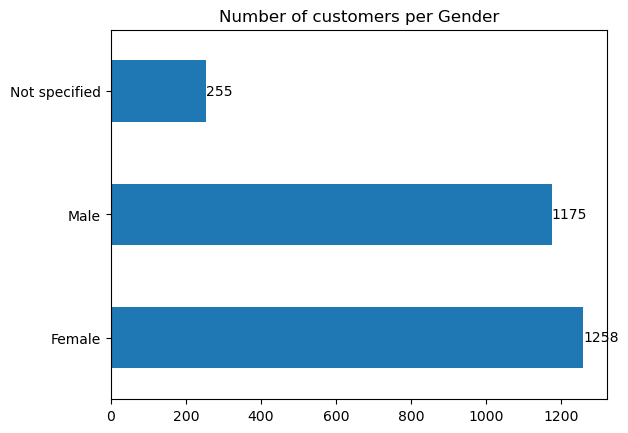

In [15]:
# the modified counts for customer_gender are:
print(tabular_df['customer_gender'].value_counts())

ax = tabular_df['customer_gender'].value_counts().plot.barh(title="Number of customers per Gender")
ax.bar_label(ax.containers[0])


Check the quality of *customer_age* feature

In [16]:
# Check for null values
tabular_df["customer_age"].isnull().sum()

470

In [17]:
tabular_df["customer_age"].describe()

count    2530.000000
mean       47.281818
std        14.655691
min        18.000000
25%        35.000000
50%        48.000000
75%        58.000000
max        92.000000
Name: customer_age, dtype: float64

In [18]:
tabular_df["customer_age"]

customer_id
216604    50.0
259276    61.0
265459    63.0
58770      NaN
318031    41.0
          ... 
322582    41.0
53418     57.0
79364      NaN
371134    42.0
109281    42.0
Name: customer_age, Length: 3000, dtype: float64

<Axes: >

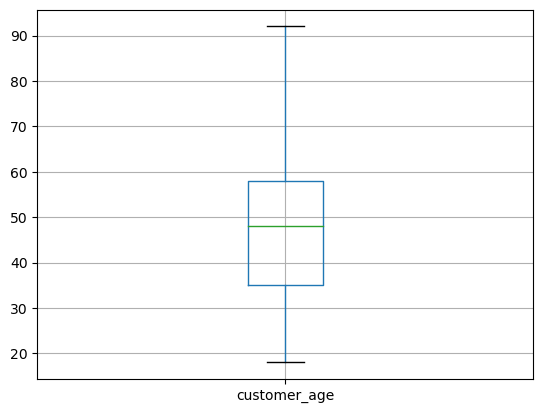

In [19]:
tabular_df.boxplot(column='customer_age', return_type='axes')

There are no outliers in customer_age feature

Check the quality of the *customer_location* feature

In [20]:
# Check for null values
tabular_df["customer_location"].isnull().sum()

365

Leinster    1248
Munster      777
Connacht     379
Ulster       231
Name: customer_location, dtype: int64


[Text(0, 0, '1248'), Text(0, 0, '777'), Text(0, 0, '379'), Text(0, 0, '231')]

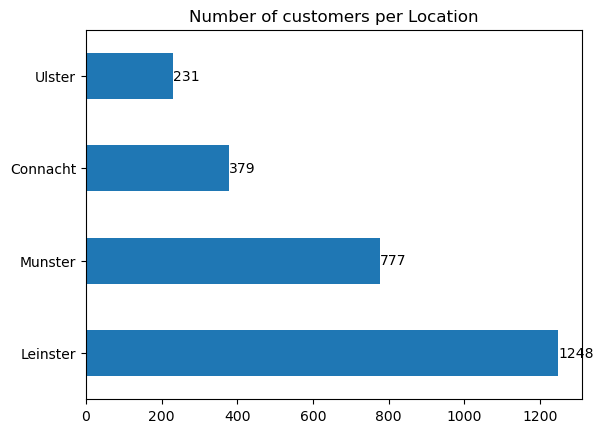

In [21]:
print(tabular_df['customer_location'].value_counts())
ax = tabular_df['customer_location'].value_counts().plot.barh(title="Number of customers per Location")
ax.bar_label(ax.containers[0])

Check quality of *customer_type*

In [22]:
# Check for null values
tabular_df["customer_type"].isnull().sum()

0

Business         1461
Personal         1371
Business-Plus     168
Name: customer_type, dtype: int64


[Text(0, 0, '1461'), Text(0, 0, '1371'), Text(0, 0, '168')]

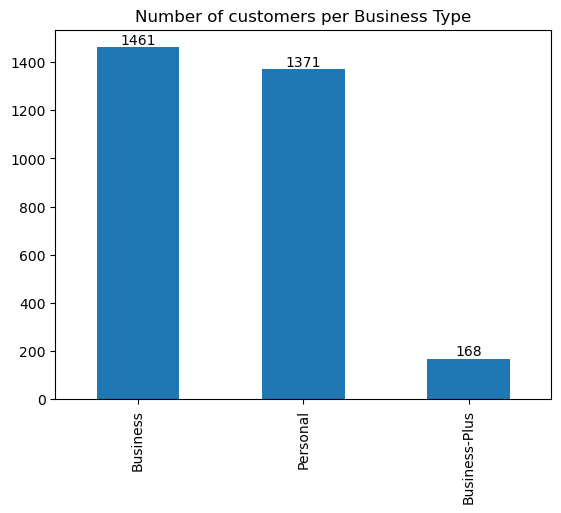

In [23]:
print(tabular_df['customer_type'].value_counts())
ax = tabular_df['customer_type'].value_counts().plot.bar(title="Number of customers per Business Type")
ax.bar_label(ax.containers[0])

Check quality of *has_cc* feature

In [24]:
# Check for null values
tabular_df["has_cc"].isnull().sum()

0

True     2512
False     488
Name: has_cc, dtype: int64


([<matplotlib.axis.YTick at 0x1df388eea30>,
 [Text(0, 0, 'Has credit card'), Text(0, 1, 'No credit card')])

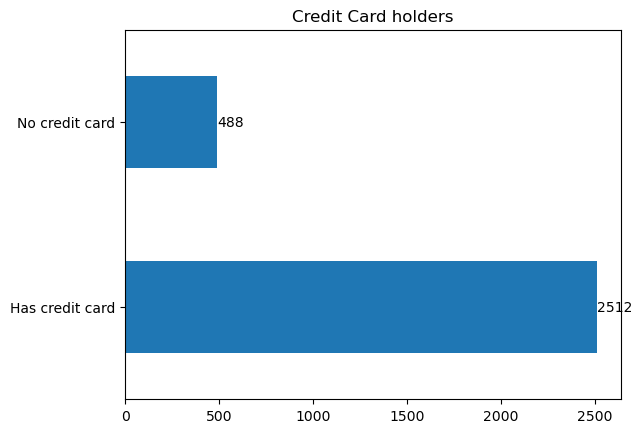

In [25]:
print(tabular_df['has_cc'].value_counts())
ax = tabular_df['has_cc'].value_counts().plot.barh(title="Credit Card holders")
ax.bar_label(ax.containers[0])
plt.yticks([0,1],['Has credit card', 'No credit card'])

Check the quality of *has_mortgage* feature

In [26]:
# Check for null values
tabular_df["has_mortgage"].isnull().sum()

0

False    2052
True      948
Name: has_mortgage, dtype: int64


([<matplotlib.axis.XTick at 0x1df3896d2b0>,
 [Text(0, 0, 'No mortgage'), Text(1, 0, 'Has mortgage')])

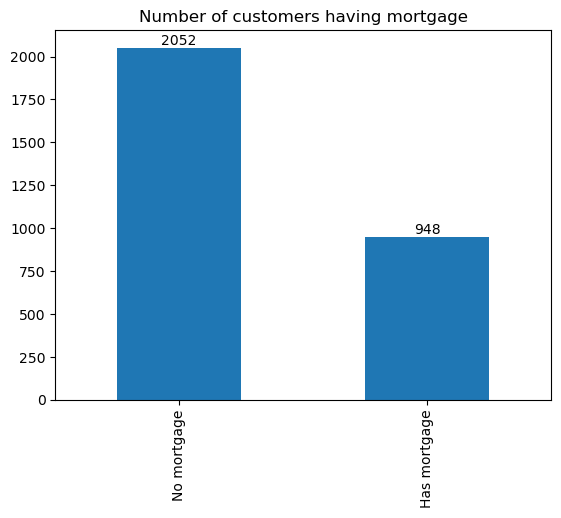

In [27]:
print(tabular_df['has_mortgage'].value_counts())
ax = tabular_df['has_mortgage'].value_counts().plot.bar(title="Number of customers having mortgage")
ax.bar_label(ax.containers[0])
plt.xticks([0,1],['No mortgage', 'Has mortgage'])

Check the quality of rating scores (i.e., convenience, customer_service, online_banking, interest_rates, fees_charges, community_involvement, products_services, privacy_security and reputation)

In [28]:
# Create a detaframe containing only the rating scores
scoring_df = tabular_df[['convenience', 'customer_service', 'online_banking', 'interest_rates', 'fees_charges', 
                      'community_involvement', 'products_services', 'privacy_security', 'reputation']]
scoring_df.shape

(3000, 9)

Text(0, 0.5, 'Measure Score')

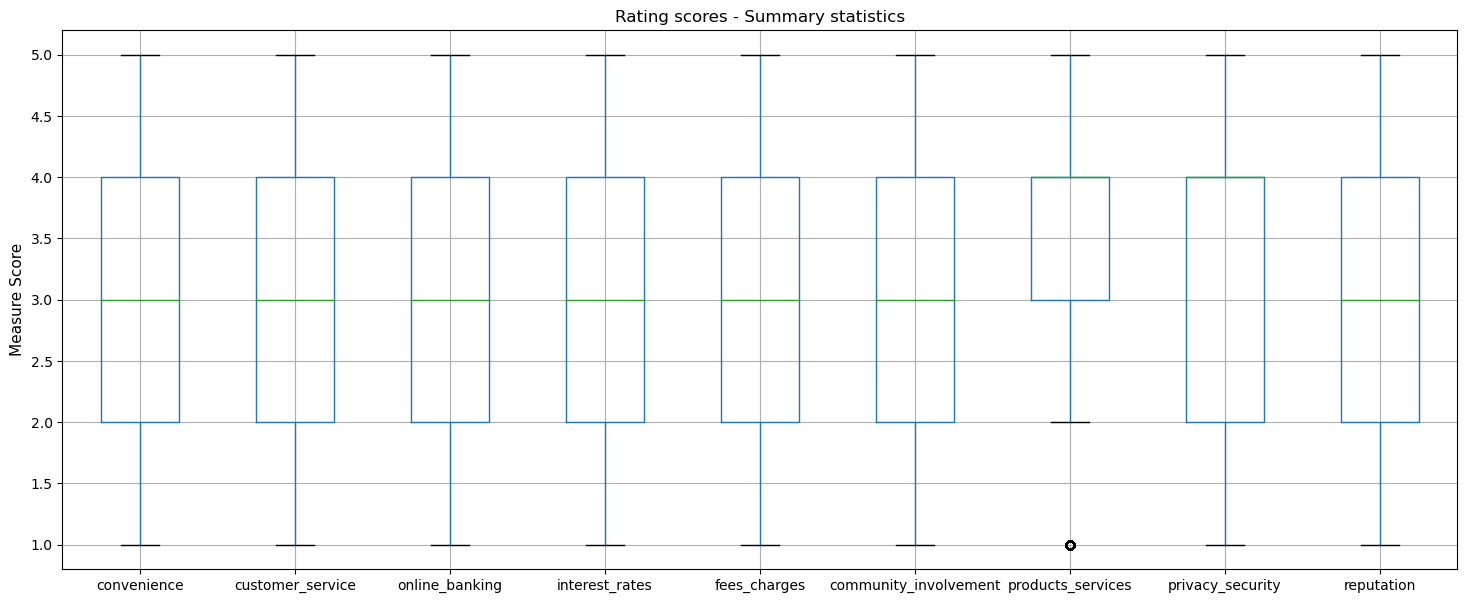

In [29]:
scoring_df.boxplot(figsize=(18,7), fontsize=10)
#plt.xlabel( "Measure", fontsize=11 )
plt.title("Rating scores - Summary statistics")
plt.ylabel( "Measure Score", fontsize=11 )
#plt.xticks(rotation=90)

All rating scores, except products_services have similar statistics. 

In [30]:
IQR_products_services = tabular_df["products_services"].quantile(0.75) - tabular_df["products_services"].quantile(0.25)
print("IQR for product_services is: ", IQR_products_services)
IQR_reputation = tabular_df["reputation"].quantile(0.75) - tabular_df["reputation"].quantile(0.25)
print("IQR for reputation is: ", IQR_reputation)

IQR for product_services is:  1.0
IQR for reputation is:  2.0


The spread of the middle half (IQR) of product_services feature is 1.0 while for the rest rating scores is 2.0 (aprx)

Check quality of *products_services* feature

In [31]:
# Check for null values
tabular_df["products_services"].isnull().sum()

100

<Axes: >

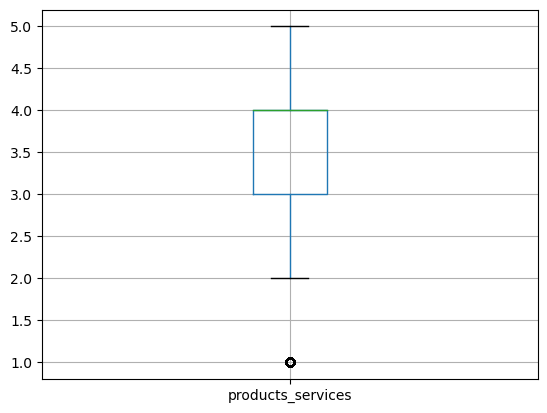

In [32]:
tabular_df.boxplot(column='products_services', return_type='axes')

It looks that some outliers exist. Check the values of the feature

In [33]:
tabular_df['products_services'].value_counts()

4.0    939
3.0    678
5.0    585
2.0    383
1.0    315
Name: products_services, dtype: int64

It seems that there are no outliers.

Check the quality of *satisfied* feature

In [34]:
# Check for null values
tabular_df["satisfied"].isnull().sum()

0

False    1737
True     1263
Name: satisfied, dtype: int64


([<matplotlib.axis.YTick at 0x1df38e9deb0>,
 [Text(0, 0, 'Not satisfied'), Text(0, 1, 'Satisfied')])

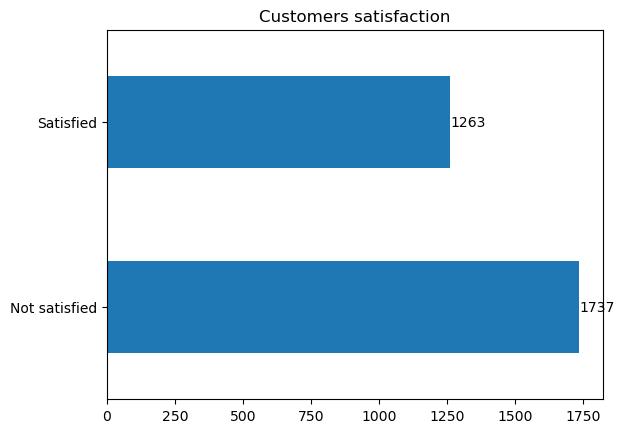

In [35]:
print(tabular_df['satisfied'].value_counts())
ax = tabular_df['satisfied'].value_counts().plot.barh(title="Customers satisfaction")
ax.bar_label(ax.containers[0])
plt.yticks([0,1],['Not satisfied', 'Satisfied'])

## Task 2 - Data Characterization

Analyze how may credit cards and mortgage holders are satisfied (or not satisfied) with bank's services. 

[Text(0, 0, '1170'), Text(0, 0, '93')]

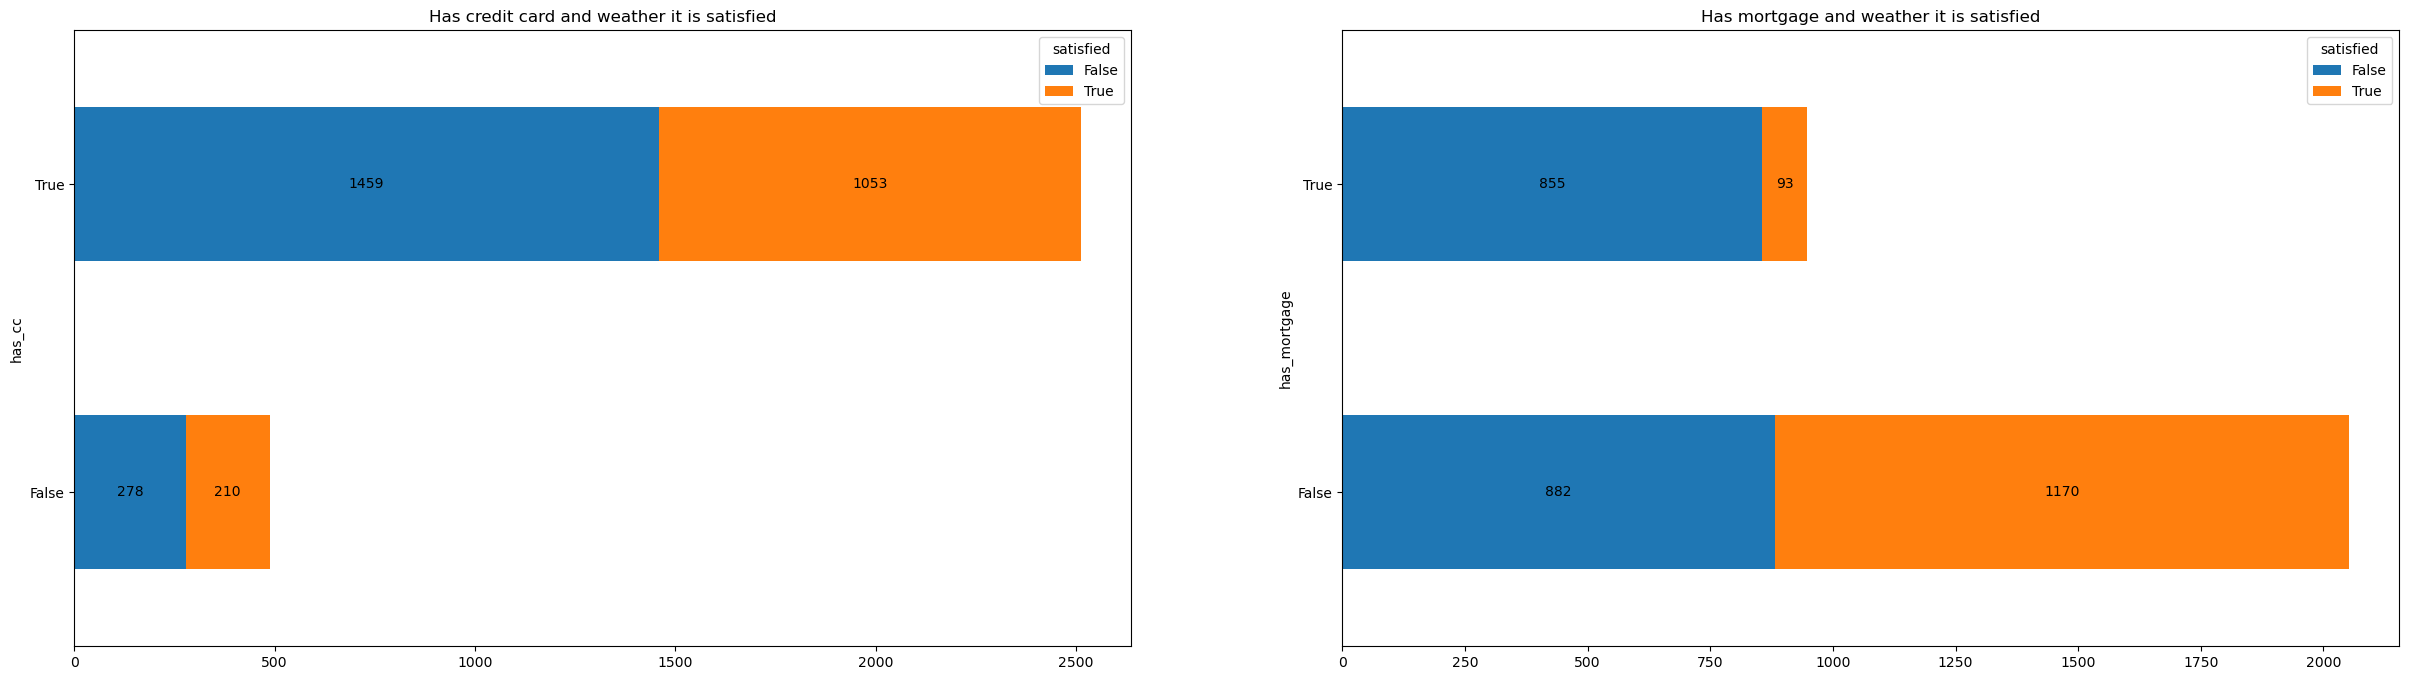

In [36]:
#set figure size
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(30)

#plot the barplot for the figure
ax1 = pd.crosstab(tabular_df['has_cc'],tabular_df['satisfied']).plot.barh(title="Has credit card and weather it is satisfied",ax=axes[0],stacked=True)
ax1.bar_label(ax1.containers[0], label_type = 'center')
ax1.bar_label(ax1.containers[1], label_type = 'center')
#plot the barplot for the figure
ax2 = pd.crosstab(tabular_df['has_mortgage'],tabular_df['satisfied']).plot.barh(title="Has mortgage and weather it is satisfied",ax=axes[1],stacked=True)
ax2.bar_label(ax2.containers[0], label_type = 'center')
ax2.bar_label(ax2.containers[1], label_type = 'center')

From the 2512 customer that have credit card, 1459 are not satisfied by bank's services. Only 488 customers do not have credit card and from those 278 are not satisfied.

From those customers that do not have mortgage (2052), the 1170 have positive opinion for bank's services. On the contrary, for those customers that have mortgage (948), the vast majority (855 customers) are not satisfied with bank. 

Ploting with a swarm plot: The customer Age and the customer Gender grouped by the customer satisfaction

[Text(-27.125, 0.5, '')]

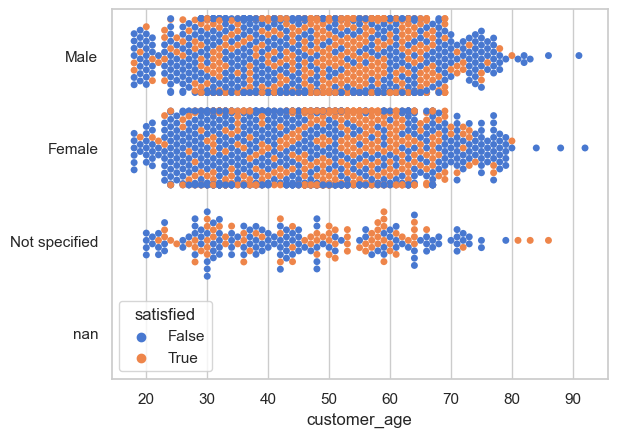

In [37]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=tabular_df, x="customer_age", y="customer_gender", hue="satisfied")
ax.set(ylabel="")

From the previous plot we can see that both the male and female customers that are satified with the bank are between the ages of 45-70. On the contrary the rest of the age groups are more unsatisfied with their bank. 
Although, there are some values that the gender is not specified the satifaction of those people follows a similar patern as before. Where more satisfied people are between the ages of 45 and 70

Barplot of the different age grous the customers and A Scatterplot to find out whether the customer location and age has an impact in the satisfaction of the customer

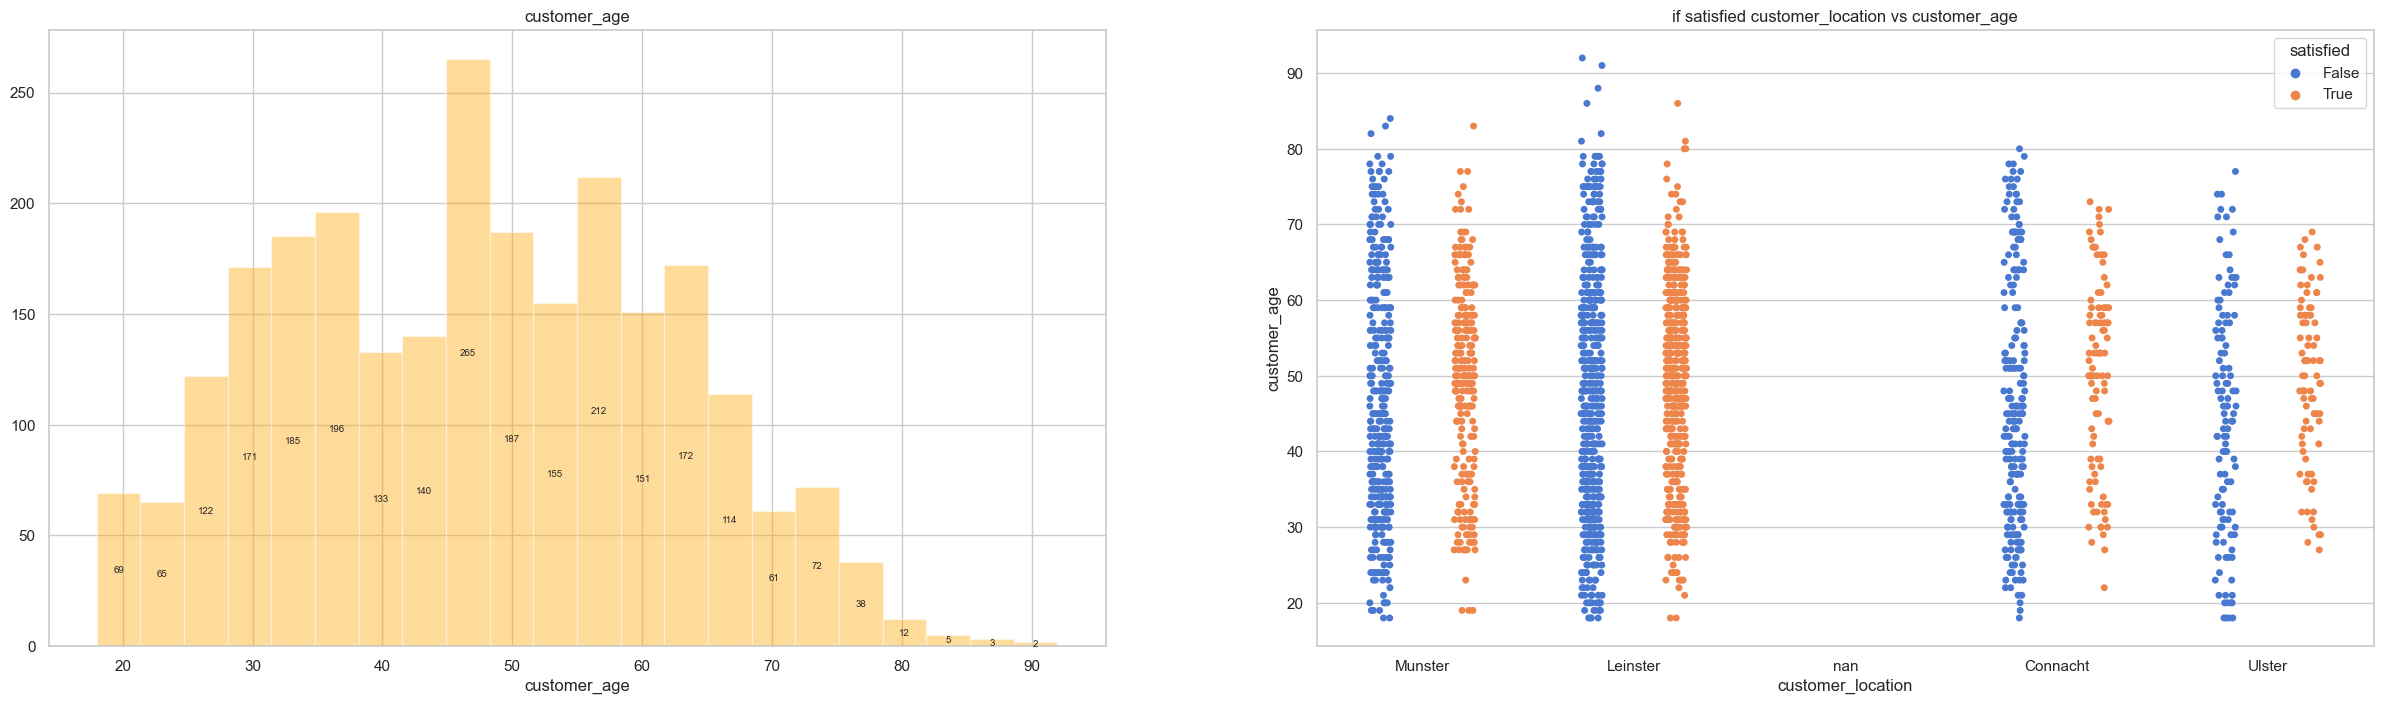

In [38]:
#set figure size
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(30)

ax1 = sns.distplot(tabular_df['customer_age'], kde=False, rug=False,color='orange',ax=axes[0])
ax1.bar_label(ax1.containers[0],label_type='center',fontsize=7)
ax1.set_title('customer_age')


ax2 = sns.stripplot(x ='customer_location', y ='customer_age', data = tabular_df, jitter = True, hue ='satisfied', dodge = True)
ax2.set_title('if satisfied customer_location vs customer_age')
plt.show()

For the left plot it is visible that the age groups with the most customer are 25-35 and 45-65 years old.

On the right plot it is visible that most of the customers live in the leinster providence and also it is visible that the age groups 18-30 and 70-95 are more unsatisfied with their bank

Making 2 plots. A Barplot with the gender of customers and their satisfaction. A Pie plot to show the presentage of the customers based on their gender.

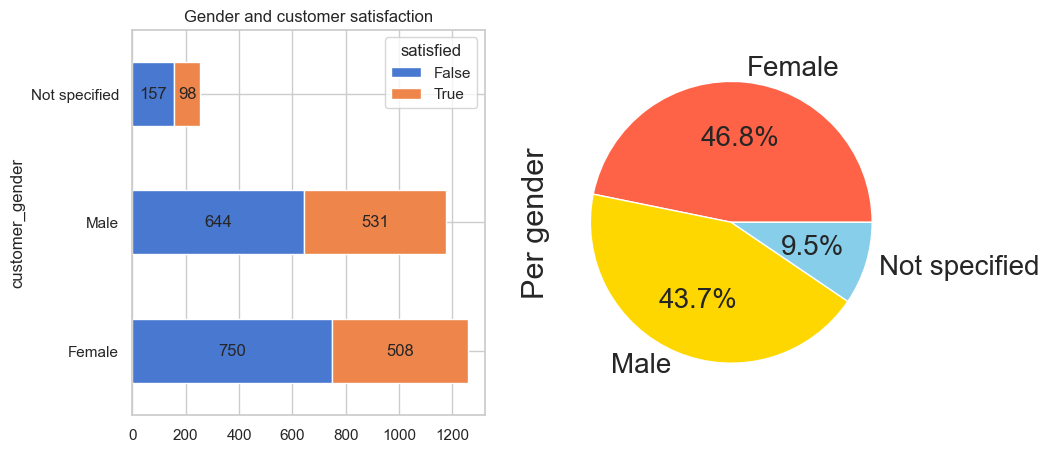

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

ax1 = tabular_df.groupby('customer_gender').size().plot(kind='pie', autopct='%1.1f%%',textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'], ax=axes[1])
ax1.set_ylabel('Per gender', size=22)


#plot the barplot for the figure
ax2 = pd.crosstab(tabular_df['customer_gender'],tabular_df['satisfied']).plot.barh(title="Gender and customer satisfaction",ax=axes[0],stacked=True)
ax2.bar_label(ax2.containers[0], label_type = 'center')
ax2.bar_label(ax2.containers[1], label_type = 'center')
plt.show()

From the Barplot we see that the customers are unsatisfied with their bank no matter their gender. From this graph it is also visible that the female customers are less satisfied with the bank than the male customers but not by much.
In addition, from the pie graph on the right it is visible that the precentace of male and female customers are very close.

 Making 2 plots. A Barplot with the location of customers and their satisfaction. A Pie plot to show the presentage of the customers based on their location.

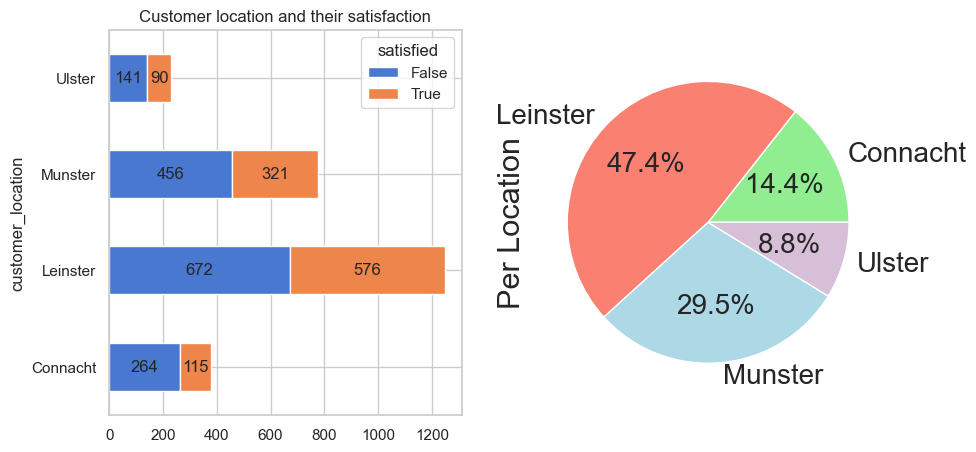

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

ax1 = tabular_df.groupby('customer_location').size().plot(kind='pie', autopct='%1.1f%%',textprops={'fontsize': 20},
                                  colors=['lightgreen', 'salmon', 'lightblue','thistle'], ax=axes[1])
ax1.set_ylabel('Per Location', size=22)


#plot the barplot for the figure
ax2 = pd.crosstab(tabular_df['customer_location'],tabular_df['satisfied']).plot.barh(title="Customer location and their satisfaction",ax=axes[0],stacked=True)
ax2.bar_label(ax2.containers[0], label_type = 'center')
ax2.bar_label(ax2.containers[1], label_type = 'center')
plt.show()

From the pie graph it is visible that most of the customers (the 47%) of the bank live in the Leinster providence and almost half of them are unsatisfied with the bank. 
From the barplot on the left we can find out that from these four providences the Connact is least satisfied with the bank.

 Barplots with the 1 - 5 evaluation results of the 9 questions.

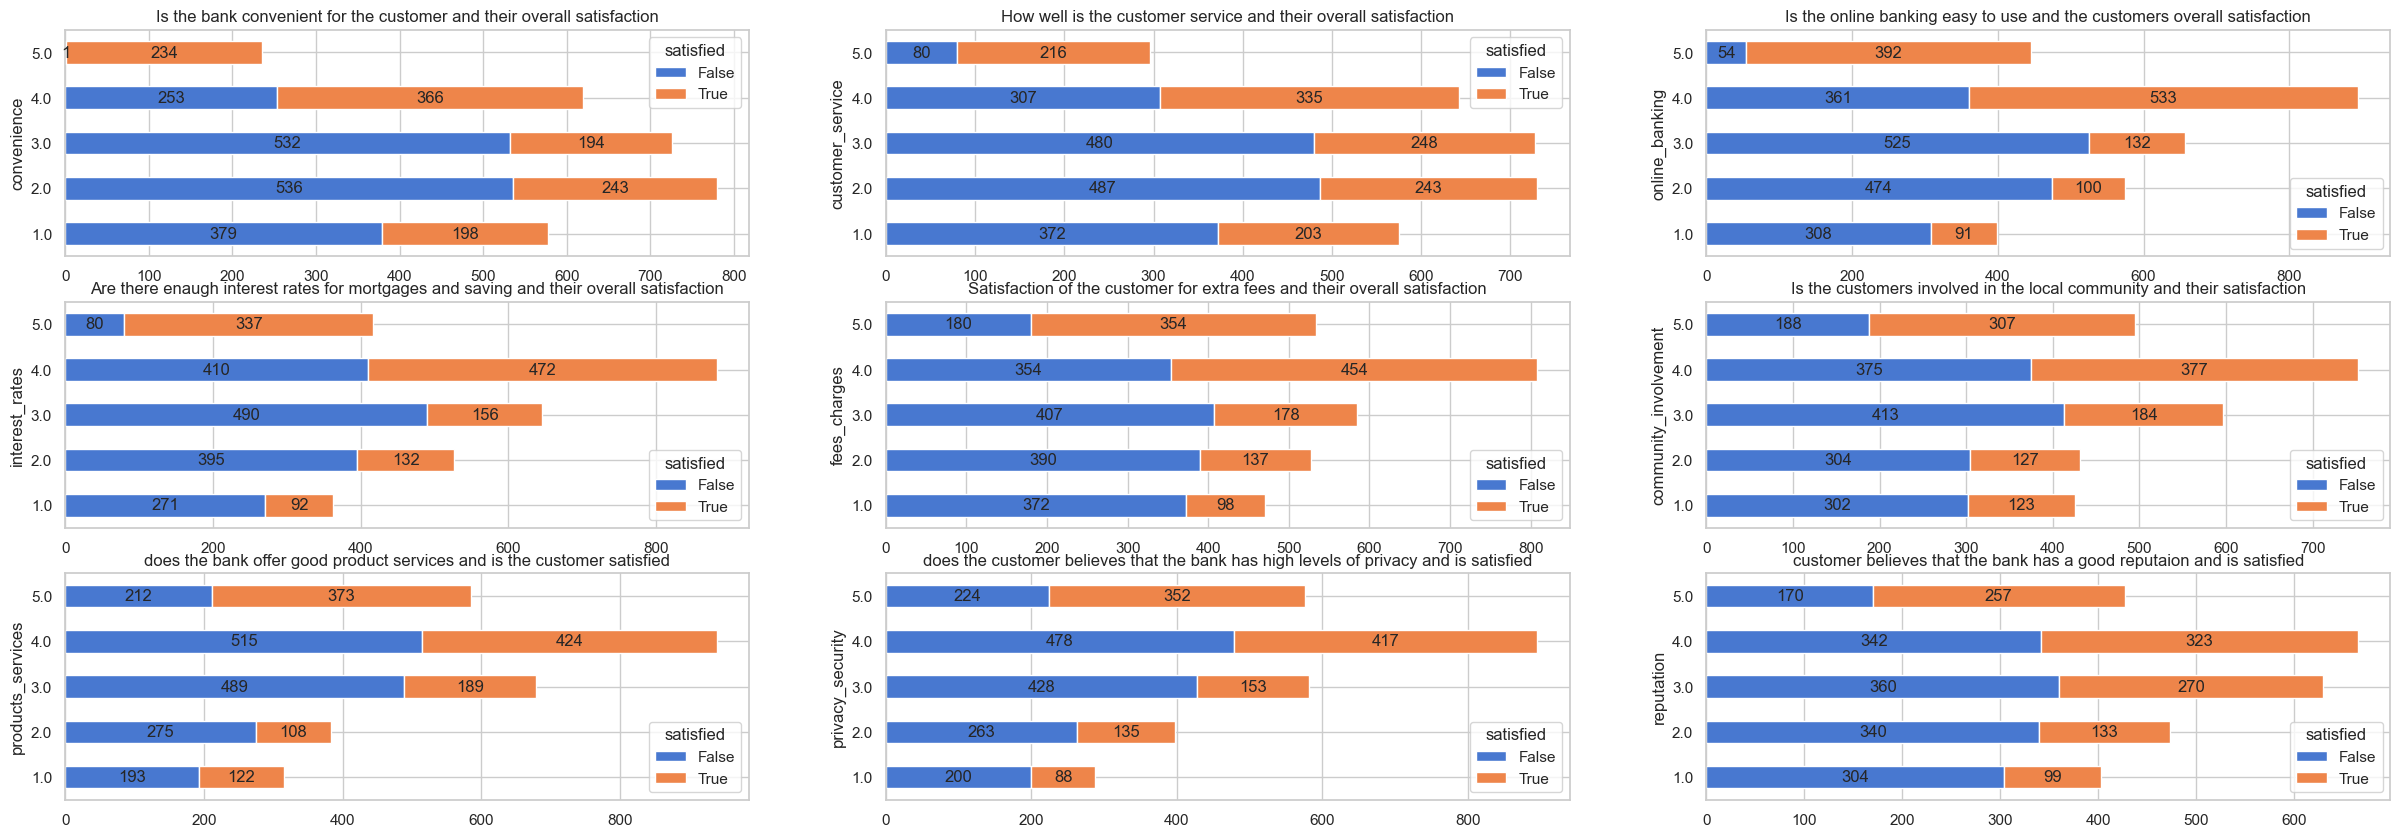

In [42]:
#set figure size
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(30)
#plot the first barplot 
ax1 = pd.crosstab(tabular_df['convenience'],tabular_df['satisfied']).plot.barh(title="Is the bank convenient for the customer and their overall satisfaction",ax=axes[0,0],stacked=True)
ax1.bar_label(ax1.containers[0], label_type = 'center')
ax1.bar_label(ax1.containers[1], label_type = 'center')
#plot the second barplot 
ax2 = pd.crosstab(tabular_df['customer_service'],tabular_df['satisfied']).plot.barh(title="How well is the customer service and their overall satisfaction",ax=axes[0,1],stacked=True)
ax2.bar_label(ax2.containers[0], label_type = 'center')
ax2.bar_label(ax2.containers[1], label_type = 'center')
#plot the third barplot 
ax3 = pd.crosstab(tabular_df['online_banking'],tabular_df['satisfied']).plot.barh(title="Is the online banking easy to use and the customers overall satisfaction",ax=axes[0,2],stacked=True)
ax3.bar_label(ax3.containers[0], label_type = 'center')
ax3.bar_label(ax3.containers[1], label_type = 'center')
#plot the fourth barplot 
ax4 = pd.crosstab(tabular_df['interest_rates'],tabular_df['satisfied']).plot.barh(title="Are there enaugh interest rates for mortgages and saving and their overall satisfaction",ax=axes[1,0],stacked=True)
ax4.bar_label(ax4.containers[0], label_type = 'center')
ax4.bar_label(ax4.containers[1], label_type = 'center')
#plot the fifth barplot 
ax5 = pd.crosstab(tabular_df['fees_charges'],tabular_df['satisfied']).plot.barh(title="Satisfaction of the customer for extra fees and their overall satisfaction",ax=axes[1,1],stacked=True)
ax5.bar_label(ax5.containers[0], label_type = 'center')
ax5.bar_label(ax5.containers[1], label_type = 'center')
#plot the sixth barplot 
ax6 = pd.crosstab(tabular_df['community_involvement'],tabular_df['satisfied']).plot.barh(title="Is the customers involved in the local community and their satisfaction",ax=axes[1,2],stacked=True)
ax6.bar_label(ax6.containers[0], label_type = 'center')
ax6.bar_label(ax6.containers[1], label_type = 'center')
#plot the seventh barplot 
ax7 = pd.crosstab(tabular_df['products_services'],tabular_df['satisfied']).plot.barh(title="does the bank offer good product services and is the customer satisfied",ax=axes[2,0],stacked=True)
ax7.bar_label(ax7.containers[0], label_type = 'center')
ax7.bar_label(ax7.containers[1], label_type = 'center')
#plot the eighth barplot 
ax8 = pd.crosstab(tabular_df['privacy_security'],tabular_df['satisfied']).plot.barh(title="does the customer believes that the bank has high levels of privacy and is satisfied",ax=axes[2,1],stacked=True)
ax8.bar_label(ax8.containers[0], label_type = 'center')
ax8.bar_label(ax8.containers[1], label_type = 'center')
#plot the nineth barplot 
ax9 = pd.crosstab(tabular_df['reputation'],tabular_df['satisfied']).plot.barh(title="customer believes that the bank has a good reputaion and is satisfied",ax=axes[2,2],stacked=True)
ax9.bar_label(ax9.containers[0], label_type = 'center')
ax9.bar_label(ax9.containers[1], label_type = 'center')
plt.show()

From the fist barplot we can see that the overall satisfaction of the customers is very closely related with the rating score of the accesiblity of the bank(convenience). The same can be said for the customer_service, online_banking and interest_rates graph values. For the 5-7 graphs the overal satisfaction of the customer has some relation with the fees_charges, community_involvment and product_services values but with the rating of 5 there are a lot of customers that are unsatisfied with the bank.
In the last two graphs it seems that the privacy_security and reputation of the bank are not very importand for the satisfaction of the customers.

Verify whether customer satisfaction levels are changing over time.

In [43]:
# Create the temporal_df dataframe
temporal_df = tabular_df.copy(deep=True)
temporal_df = temporal_df.reset_index(drop=True)
print(temporal_df.shape)
print(temporal_df.index)

(3000, 17)
RangeIndex(start=0, stop=3000, step=1)


In [44]:
# For satisfied feature turn 'True' value to 1 and 'False' value to 0
temporal_df["satisfied"] = np.where(temporal_df["satisfied"] == True, 1, 0)

In [45]:
# Filter 'date' and 'satisfied' features
satisfied_df = temporal_df[['date','satisfied']]

In [46]:
satisfied_df = satisfied_df.sort_values(by=['date'], ascending=True)
satisfied_df.head(5)

,date,satisfied
1737,2021-01-05,0
886,2021-01-05,0
1707,2021-01-05,0
1790,2021-01-05,0
2671,2021-01-06,1


To verify whether customer satisfation levels are changing over time, count the number of customers that are satisfied / not satisfied per date.

In [47]:
count_df = (satisfied_df.reset_index()
          .groupby(['date','satisfied'], as_index=False)
          .count()
          # rename isn't strictly necessary here, it's just for readability
          .rename(columns={'index':'ct'})
       )
count_df.head(5)

,date,satisfied,ct
0,2021-01-05,0,4
1,2021-01-06,0,2
2,2021-01-06,1,5
3,2021-01-07,0,3
4,2021-01-07,1,1


Compute customer satisfaction levels per year quarter 

In [48]:
q1_2021_df = count_df[count_df['date']<='2021-06-30']
dmin, dmax = q1_2021_df['date'].min(), q1_2021_df['date'].max()
print("Q1-2021 Dates Range is : ", dmin, "-", dmax)

q2_2021_df = count_df[(count_df['date']>'2021-06-30') & (count_df['date']<='2021-12-31') ]
dmin, dmax = q2_2021_df['date'].min(), q2_2021_df['date'].max()
print("Q1-2021 Dates Range is : ", dmin, "-", dmax)

q1_2022_df = count_df[(count_df['date']>='2022-01-01') & (count_df['date']<='2022-06-30')]
dmin, dmax = q1_2022_df['date'].min(), q1_2022_df['date'].max()
print("Q1-2021 Dates Range is : ", dmin, "-", dmax)

q2_2022_df = count_df[count_df['date']>'2022-06-30']
dmin, dmax = q2_2022_df['date'].min(), q2_2022_df['date'].max()
print("Q1-2021 Dates Range is : ", dmin, "-", dmax)

Q1-2021 Dates Range is :  2021-01-05 00:00:00 - 2021-06-30 00:00:00
Q1-2021 Dates Range is :  2021-07-01 00:00:00 - 2021-12-22 00:00:00
Q1-2021 Dates Range is :  2022-01-05 00:00:00 - 2022-06-30 00:00:00
Q1-2021 Dates Range is :  2022-07-01 00:00:00 - 2022-12-22 00:00:00


It seems that for 2021 year there are data from 2021-01-05 till 2021-12-22 while for 2022 year there are data from 2022-01-05 till 2022-12-22. Therefore, instead of year quarter, yearly visualizations will be produced.

In [49]:
y2021_df = count_df[count_df['date']<='2021-12-31']
dmin2021, dmax2021 = y2021_df['date'].min(), y2021_df['date'].max()
print("Year-2021 Dates Range is : ", dmin2021, "-", dmax2021)


y2022_df = count_df[count_df['date']>='2022-01-05']
dmin2022, dmax2022 = q2_2022_df['date'].min(), q2_2022_df['date'].max()
print("Year-2021 Dates Range is : ", dmin2022, "-", dmax2022)

Year-2021 Dates Range is :  2021-01-05 00:00:00 - 2021-12-22 00:00:00
Year-2021 Dates Range is :  2022-07-01 00:00:00 - 2022-12-22 00:00:00


Customer satisfaction levels for year 2021

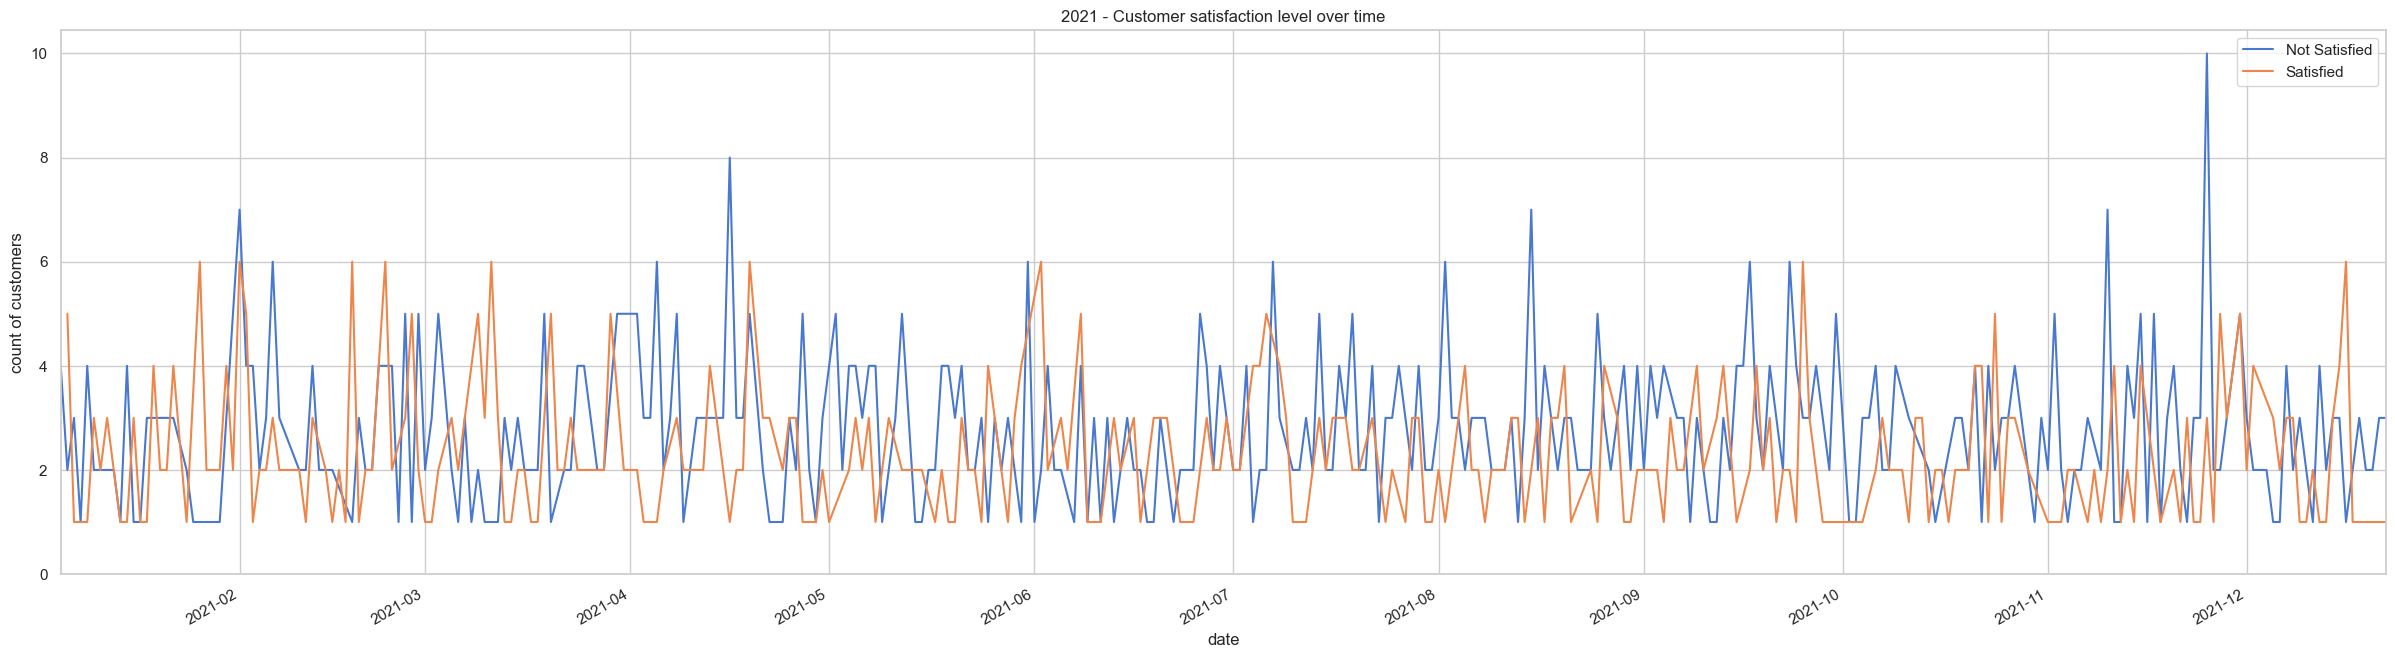

In [50]:
fig, ax = plt.subplots(figsize=(30, 8))
for key, data in y2021_df.groupby('satisfied'):
    if key == 0:
        lb = "Not Satisfied"
        #color = "red"
    else:
        lb = "Satisfied"
        #color = "green"
    data.plot(x='date', y='ct', ax=ax, label=lb, title='2021 - Customer satisfaction level over time')
    ax.set_ylabel("count of customers")
    # ensure the y-axis starts at 0
    ax.set_ylim(0)
    # only include the exact time period of the data
    ax.set_xlim(dmin2021, dmax2021);

Overall, during year 2021, the number of customers that are unsatisfied with bank's services is larger that the number of satisfied customers. 

Although, during the first months on the survey both numbers (of satisfied /not satisfied customers) look like simiral, for the rest months, the negative opinions overule. 

Customer satisfaction levels for year 2022

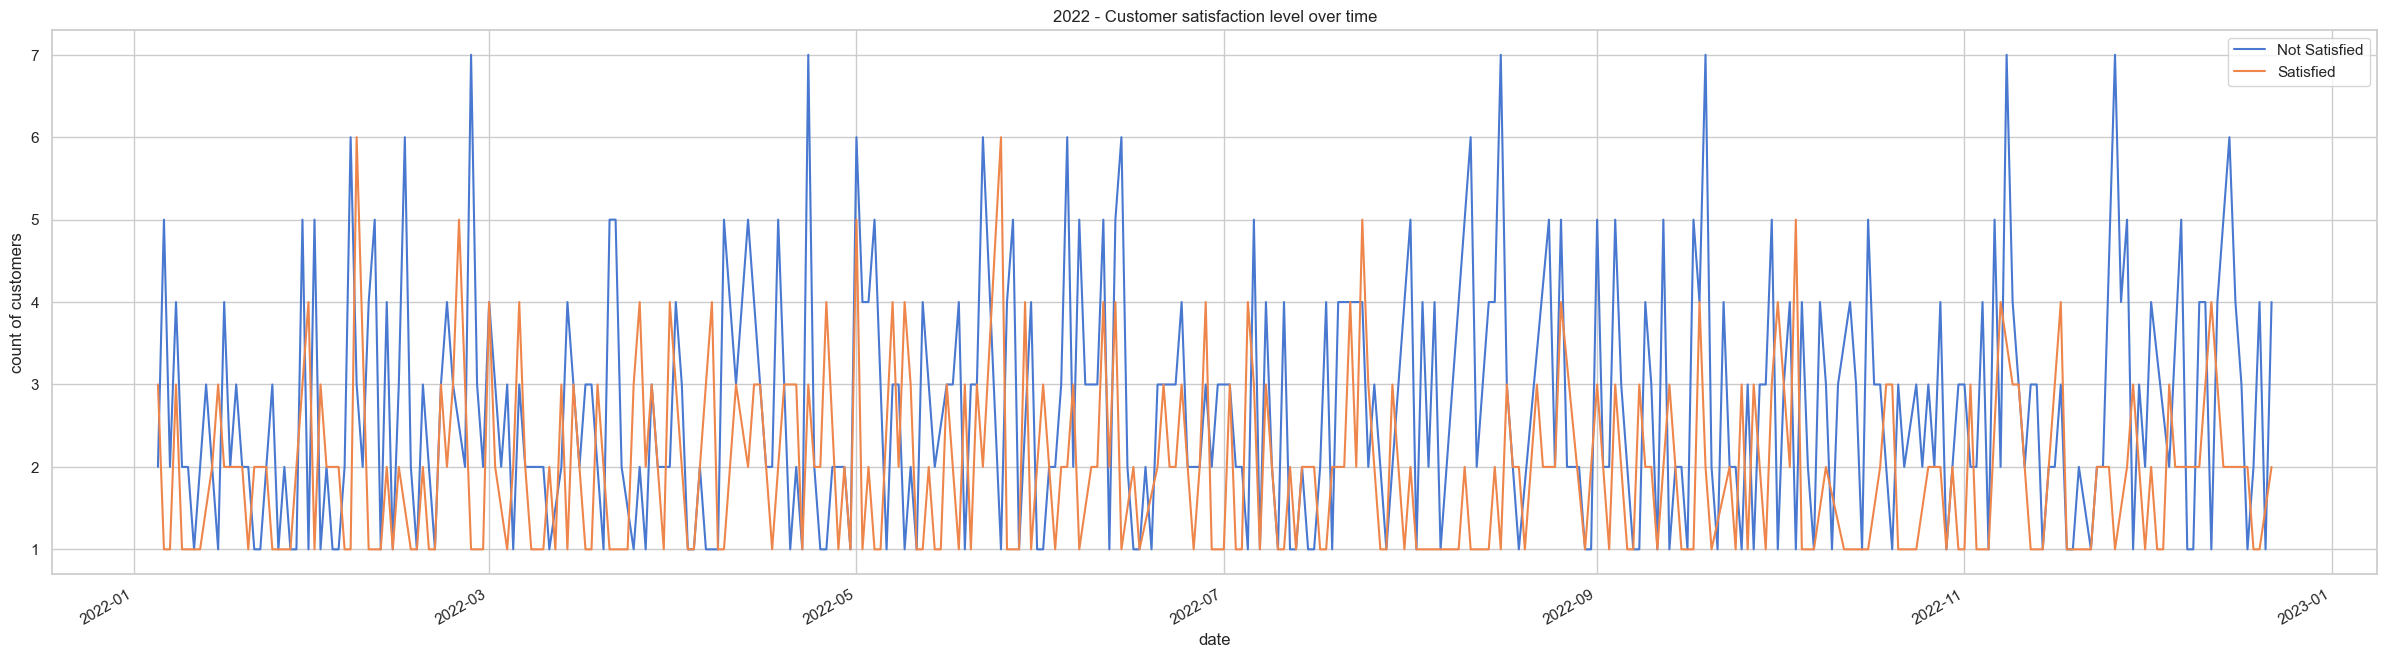

In [51]:
fig, ax = plt.subplots(figsize=(30, 8))
for key, data in y2022_df.groupby('satisfied'):
    if key == 0:
        lb = "Not Satisfied"
        #color = "red"
    else:
        lb = "Satisfied"
        #color = "green"
    data.plot(x='date', y='ct', ax=ax, label=lb, title='2022 - Customer satisfaction level over time')
    ax.set_ylabel("count of customers")

The customers opinion for the bank services improved in year 2022 when compared year 2021. The number of unsatisfied customers is still larger that the number of satisfied customers. 

## Task 3 - Tabular Data Classification

### Prepare data for Classification


In [52]:
# Get a deep copy of tabular_df 

tab_df = tabular_df.copy(deep=True)
tab_df.shape

(3000, 17)

Check whether the dataset is balanced

In [53]:
# Check whether the `satisfied` outcome is balanced
tab_df['satisfied'].value_counts()

False    1737
True     1263
Name: satisfied, dtype: int64

The dataset is balanced.

Drop the rows containg null values

In [54]:
# drop the null values
tab_df = tab_df.dropna()
tab_df.shape

(1209, 17)

The dataset has no outliers.

The dataset contains nominal categorical variables. Use of One-hoting encoding technique to covert each categorical variable to dummy numeric variables.

In [55]:
tab_df = pd.get_dummies(tab_df,prefix=["gen","loc", "type", "cc", "mort"],columns=["customer_gender","customer_location","customer_type", "has_cc", "has_mortgage"])

Turn date from string type to timestamp

In [56]:
tab_df['date'] = pd.to_datetime(tab_df['date'])
tab_df['date']= tab_df['date'].map(datetime.toordinal)

Create 2 new dataframe:
1. `data` dataframe that contains all features
2. `target` dataframe that contains the `satisfied` feature as outcome.


In [57]:
#Move `satisfied` outcome to `target` dataframe
#and drop it from dataset

#tab_df["satisfied"] = np.where(tab_df["satisfied"] == True, 1, 0)
target = tab_df["satisfied"]
print("Target shape is: ", target.shape)
data = tab_df.drop(['satisfied'], axis=1)
print("Data shape is: ", data.shape)

Target shape is:  (1209,)
Data shape is:  (1209, 25)


Split `data` dataframe to training dataset (80%) and testing dataset (20%)

In [58]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=1)
print("Training set has %d examples" % data_train.shape[0])
print("Test set has %d examples" % data_test.shape[0])

Training set has 967 examples
Test set has 242 examples


Normalize numerical features in data_train dataset.

In [59]:
# Normalize numerical features in data_train dataset
min_max_scaler = preprocessing.MinMaxScaler()
arr_scaled = min_max_scaler.fit_transform(data_train)
data_train = pd.DataFrame(arr_scaled, columns=data_train.columns,index=data_train.index)
data_train.head()

,date,customer_age,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,...,loc_Leinster,loc_Munster,loc_Ulster,type_Business,type_Business-Plus,type_Personal,cc_False,cc_True,mort_False,mort_True
customer_id,,,,,,,,,,,,,,,,,,,,,
299414,0.758042,0.528571,0.00,0.50,0.50,0.75,0.00,0.00,0.00,0.00,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
214965,0.376224,0.057143,0.75,0.75,0.75,0.00,0.25,0.50,0.25,0.75,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
310529,0.544056,0.457143,1.00,1.00,0.75,0.25,0.75,0.75,0.75,0.75,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
167925,0.423776,0.428571,0.50,0.75,1.00,1.00,0.75,0.75,0.25,0.75,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
234020,0.552448,0.600000,0.50,0.50,0.50,0.50,0.00,0.50,1.00,0.75,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


Normalize numerical features in data_test dataset

In [60]:
# Normalize numerical features in data_test dataset
min_max_scaler = preprocessing.MinMaxScaler()
arr_scaled = min_max_scaler.fit_transform(data_test)
data_test = pd.DataFrame(arr_scaled, columns=data_test.columns,index=data_test.index)
data_test.head()

,date,customer_age,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,...,loc_Leinster,loc_Munster,loc_Ulster,type_Business,type_Business-Plus,type_Personal,cc_False,cc_True,mort_False,mort_True
customer_id,,,,,,,,,,,,,,,,,,,,,
336346,0.645658,0.178082,0.00,0.00,0.75,0.25,0.75,0.50,0.50,0.50,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
242125,0.161064,0.684932,0.25,0.00,0.50,0.75,0.25,0.25,0.25,0.50,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
209682,0.834734,0.589041,0.75,0.75,0.50,0.25,1.00,0.75,0.75,1.00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
272245,0.648459,0.547945,0.25,0.25,0.25,0.75,0.75,0.50,0.75,0.75,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
272394,0.354342,0.780822,0.50,0.50,0.75,0.50,0.00,0.25,0.25,0.25,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


### Classify with all features

Defined `run_tabular_model` function to train and evaluate a set of classification models on all features of the dataset. The classification models are:
1. KNeighborsClassifier
2. MultinomialNB
3. DecisionTreeClassifier
4. RandomForestClassifier
5. SVC

During the model evaluation, the following evaluation measures are computed and reported:`accuracy`, `precision`, `recall` and `f1 score`. In addition, the confusion matrix is calculated and visualized.

In [61]:
def run_tabular_model(X_train, X_test, y_train, y_test):
    # Create models
    models = [KNeighborsClassifier(n_neighbors=3), MultinomialNB(), #XGBClassifier(),
              DecisionTreeClassifier(), RandomForestClassifier(n_estimators=1000, random_state=0),
              SVC(gamma='auto')]

    
    models_names = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    tps = []
    fps = []
    fns = []
    tns = []
    
    fig, axes = plt.subplots(nrows=1, ncols=5)
    fig.set_figheight(5)
    fig.set_figwidth(30)
    
    #for model, name in zip(models, names):
    i=0
    for model in models:
        model_name = type(model).__name__
        #print("Classifier: ", model_name)

        m = model.fit(X_train, y_train)

        y_pred = m.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        #print("Confusion matrix is: ", conf_matrix)
        
        plt.figure()
        #annot=True to annotate cells, ftm='g' to disable scientific notation  
        sns.heatmap(conf_matrix, annot=True, fmt='g', ax=axes[i])
        # labels, title and ticks
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
        plot_title = 'Confusion Matrix - '+ model_name
        axes[i].set_title(plot_title)
        i = i+1
    
        class_report = classification_report(y_test, y_pred, output_dict=True)
              
        models_names.append(model_name)
        accuracies.append(round(class_report["accuracy"]*100, 2))
        precisions.append(round(class_report["macro avg"]["precision"]*100, 2))
        recalls.append(round(class_report["macro avg"]["recall"]*100, 2))
        f1_scores.append(round(class_report["macro avg"]["f1-score"]*100, 2))
    
        tps.append(conf_matrix[0,0])
        fps.append(conf_matrix[1,0])
        fns.append(conf_matrix[0,1])
        tns.append(conf_matrix[1,1])
        
    results = {
        "Classifier": models_names,
        "Accuracy %": accuracies,
        "Avg Precision %": precisions,
        "Avg Recall %": recalls,
        "Avg F1 Score %": f1_scores,
        "No of TP": tps,
        "No of FN": fns,
        "No of FP": fps,
        "No of TN": tns,
    }

    results_df = pd.DataFrame(results)
    #results_df
    return results_df

In [62]:
# Run models with all features

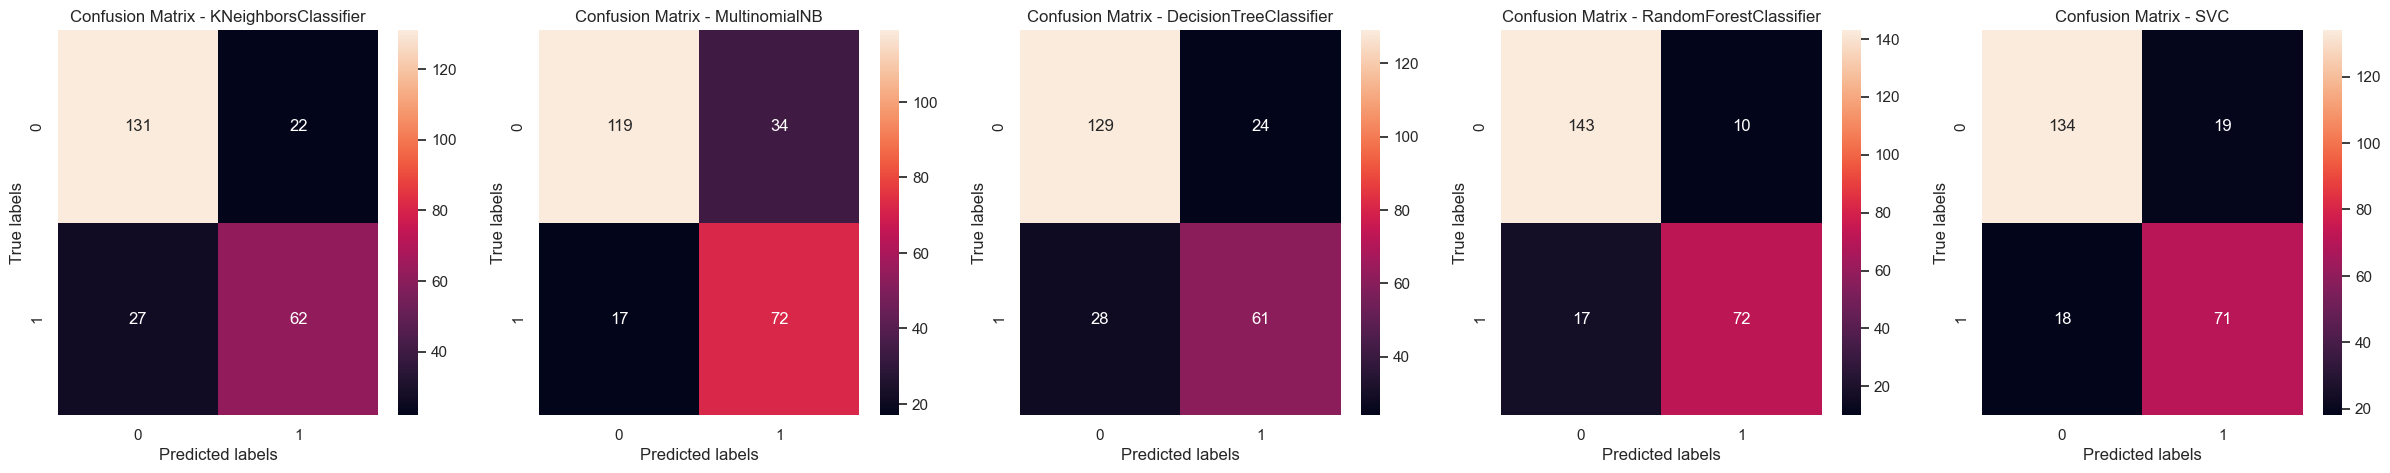

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [63]:
all_features_results_df = run_tabular_model(data_train, data_test, target_train, target_test)

The evaluation results of the trained models are:

In [64]:
all_features_results_df

,Classifier,Accuracy %,Avg Precision %,Avg Recall %,Avg F1 Score %,No of TP,No of FN,No of FP,No of TN
0,KNeighborsClassifier,79.75,78.36,77.64,77.96,131,22,27,62
1,MultinomialNB,78.93,77.71,79.34,78.10,119,34,17,72
2,DecisionTreeClassifier,78.51,76.97,76.43,76.67,129,24,28,61
3,RandomForestClassifier,88.84,88.59,87.18,87.79,143,10,17,72
4,SVC,84.71,83.52,83.68,83.60,134,19,18,71


The RandomForest Classifier has the best performance in all evaluation measures. It has 88.84% accuracy, 88.59% (macro average) precision, 88.18% (macro average ) recall and 87.79% (macro average) F1 score. It also has the less False Negatives and False Positives.

### Feature Selection

Let's proceed to select subsets of features and verify whether the models wll perform better in these subsets.

In [65]:
# Re-Join training dataset for further processing 
corr_df = pd.concat([data_train, target_train], axis=1)
corr_df.head()

,date,customer_age,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,...,loc_Munster,loc_Ulster,type_Business,type_Business-Plus,type_Personal,cc_False,cc_True,mort_False,mort_True,satisfied
customer_id,,,,,,,,,,,,,,,,,,,,,
299414,0.758042,0.528571,0.00,0.50,0.50,0.75,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,False
214965,0.376224,0.057143,0.75,0.75,0.75,0.00,0.25,0.50,0.25,0.75,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,False
310529,0.544056,0.457143,1.00,1.00,0.75,0.25,0.75,0.75,0.75,0.75,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,True
167925,0.423776,0.428571,0.50,0.75,1.00,1.00,0.75,0.75,0.25,0.75,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,True
234020,0.552448,0.600000,0.50,0.50,0.50,0.50,0.00,0.50,1.00,0.75,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,False


In [66]:
corr_df.shape

(967, 26)

Calculate how the satisfied outcome correlates with all other features. Use the Pearson's correlation.

In [67]:
# calculate the pairwise correlations
corr_df = corr_df.corr()
a = corr_df['satisfied']

Visualize the correlation's result in a heatmap

<Axes: >

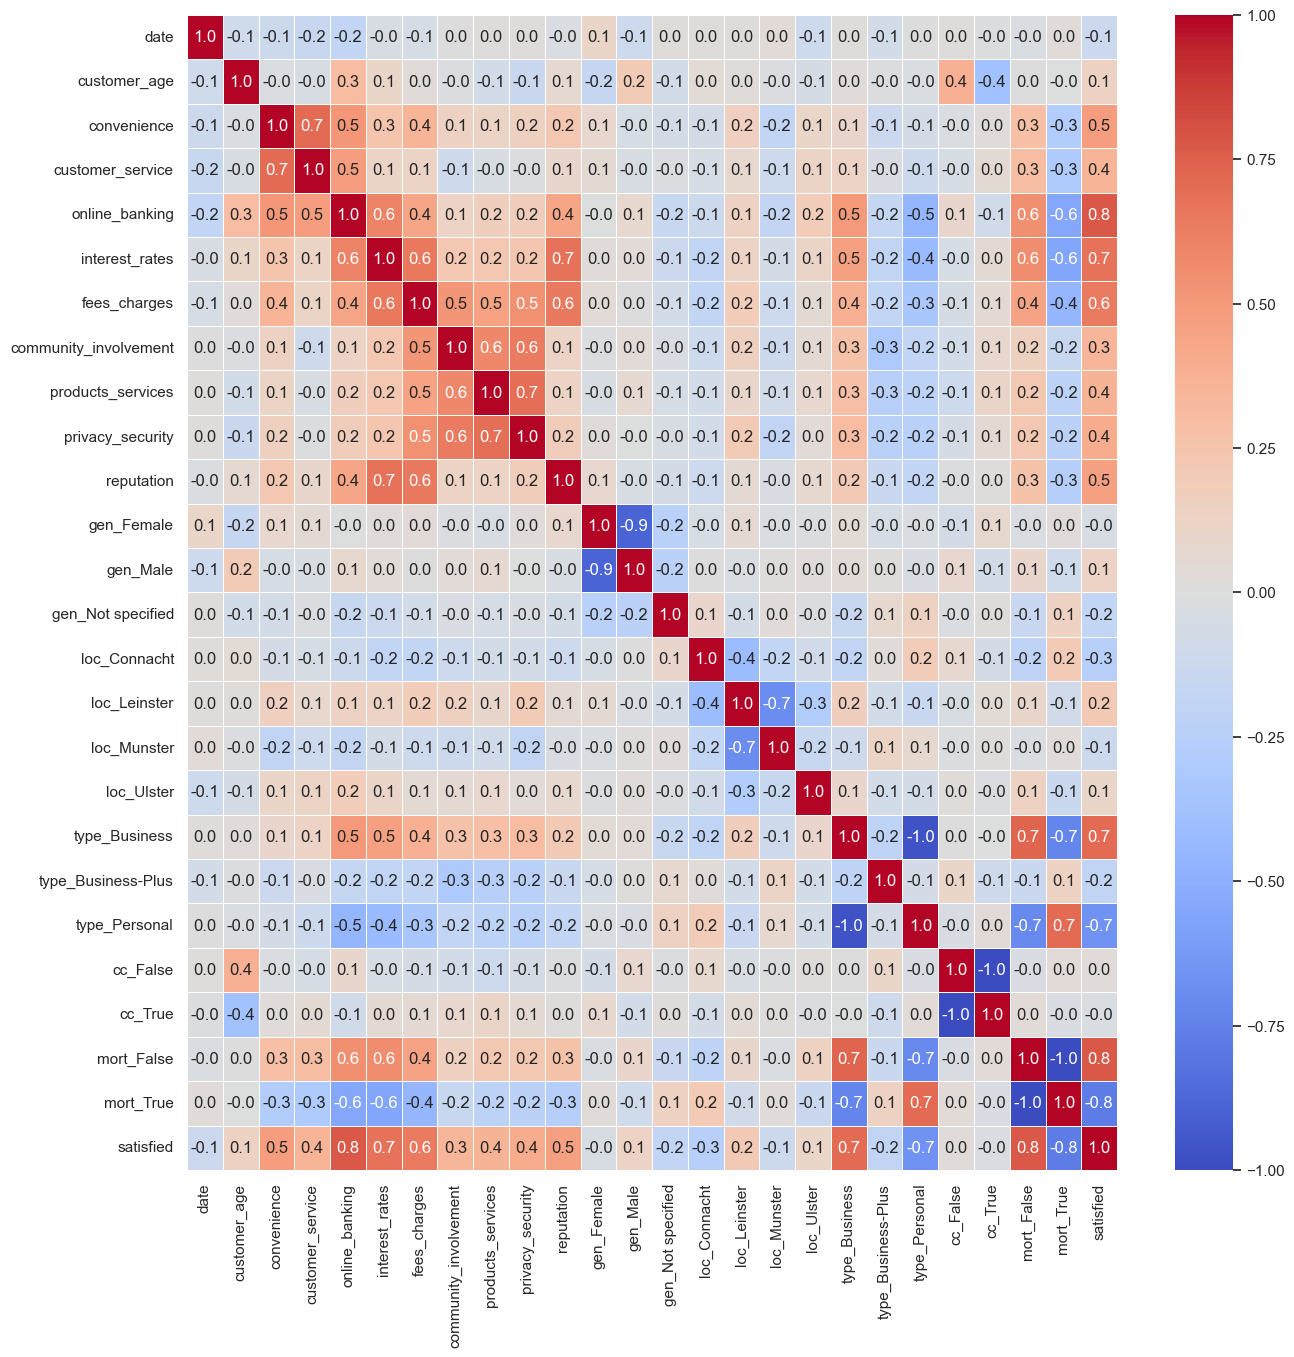

In [68]:
#Correlation map
f,ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap="coolwarm", center =0)

The features that mostly correlate to `satisfied` outcome are:
* online_baning (0.77)
* type_Business (0.7), this feature came up after one-hot encoding of `customer_type` feature and encodes the `Business` customer type
* mort_False (0.77), this feature came up after one-hot encoding of `has_mortgage` feature and encodes its `False` value
* mort_True (0.77), this feature came up after one-hot encoding of `has_mortgage` feature and encodes its `True` value


#### Run Forward & Backward feature selection

Define the `run_feature_selection` function to run, for a set of classifiers, the forward/backward feature selection process to find out the best set of features for each classifier and then to evaluate its performance via cross validation.
The classification models are:
1. KNeighborsClassifier
2. MultinomialNB
3. DecisionTreeClassifier
4. SVC

During the model evaluation, the following evaluation measures are computed and reported:`accuracy`, `precision`, `recall` and `f1 score`. 

In [69]:
def run_feature_selection(data, target, sfs_feature, sfs_direction):
    # Create models

    models = [KNeighborsClassifier(n_neighbors=3), MultinomialNB(), #XGBClassifier(),
              DecisionTreeClassifier(), 
              #RandomForestClassifier(n_estimators=1000, random_state=0),
              SVC(gamma='auto')]

    # Define custom scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='macro')
    }
    
    
    models_names = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    all_selected_features = []
    
    #for model, name in zip(models, names):
    for model in models:
        model_name = type(model).__name__
        print("Selecting features for classifier: ", model_name)
        
        sfs = SequentialFeatureSelector(model, n_features_to_select=sfs_feature, direction=sfs_direction)
        sfs = sfs.fit(data, target)

        # get the boolean mask of selected features
        feature_mask = sfs.get_support()
        data_selected = data.iloc[:, feature_mask]
        # get the names of the selected featured
        selected_features = list(data_selected.columns)
        print(selected_features)
        
        cross_val = cross_validate(model, data_selected, target, cv=5, scoring=scoring)
        # compute mean values of all scoring metrics
        # overall average accuracy
        mean_accuracy = cross_val['test_accuracy'].mean()
        #print("Mean accuracy: %.4f" % mean_accuracy)
        accuracies.append(round(mean_accuracy*100, 2))
        
        # overall average precision
        mean_precision = cross_val['test_precision'].mean()
        precisions.append(round(mean_precision*100, 2))
        #print("Mean precision: %.4f" % mean_precision)
        
        # overall average recall
        mean_recall = cross_val['test_recall'].mean()
        recalls.append(round(mean_recall*100, 2))
        #print("Mean recall: %.4f" % mean_recall)
        
        # overall average F1 score
        mean_f1_score = cross_val['test_f1_score'].mean()
        #print("Mean F1 score: %.4f" % mean_f1_score)
        f1_scores.append(round(mean_f1_score*100, 2))
        
        sf = ', '.join(selected_features)
        all_selected_features.append(sf)
                       
        models_names.append(model_name)
        
    results = {
        "Classifier": models_names,
        "Mean CV Accuracy (%)": accuracies,
        "Mean CV Precision (%)": precisions,
        "Mean CV Recall (%)": recalls,
        "Mean CV F1 Score (%)": f1_scores,
        "Selected Features": all_selected_features
    }

    results_df = pd.DataFrame(results)
    results_df
    return  results_df

*Note*. The RandomForestClassifier classifier excludes from this experiment as it took very long time to execute 

Run backward feature selection process and evaluate all models

In [70]:
sfs_feature = 3
sfs_direction = 'backward'
backward_results_df = run_feature_selection(data_train, target_train, sfs_feature, sfs_direction)

Selecting features for classifier:  KNeighborsClassifier
['convenience', 'online_banking', 'mort_True']
Selecting features for classifier:  MultinomialNB
['online_banking', 'type_Personal', 'mort_True']
Selecting features for classifier:  DecisionTreeClassifier
['convenience', 'online_banking', 'mort_True']
Selecting features for classifier:  SVC
['convenience', 'online_banking', 'mort_True']


In [71]:
backward_results_df

,Classifier,Mean CV Accuracy (%),Mean CV Precision (%),Mean CV Recall (%),Mean CV F1 Score (%),Selected Features
0,KNeighborsClassifier,84.49,84.76,84.49,83.93,"convenience, online_banking, mort_True"
1,MultinomialNB,77.35,77.26,77.35,76.28,"online_banking, type_Personal, mort_True"
2,DecisionTreeClassifier,84.29,84.38,84.29,83.75,"convenience, online_banking, mort_True"
3,SVC,84.70,84.81,84.70,84.19,"convenience, online_banking, mort_True"


The subset of the best features is different for each classifier.

With a subset of three only features, the performance of KNN and DecisionTree classifiers improved when compared with whole dataset. The rest two classifier had similar performance.

Run forward feature selection process and evaluate all models

In [72]:
sfs_feature = 3
sfs_direction = 'forward'
forward_results_df = run_feature_selection(data_train, target_train, sfs_feature, sfs_direction)
forward_results_df

Selecting features for classifier:  KNeighborsClassifier
['convenience', 'online_banking', 'type_Personal']
Selecting features for classifier:  MultinomialNB
['date', 'online_banking', 'mort_True']
Selecting features for classifier:  DecisionTreeClassifier
['convenience', 'online_banking', 'mort_False']
Selecting features for classifier:  SVC
['convenience', 'online_banking', 'mort_False']


,Classifier,Mean CV Accuracy (%),Mean CV Precision (%),Mean CV Recall (%),Mean CV F1 Score (%),Selected Features
0,KNeighborsClassifier,81.69,82.00,81.69,80.85,"convenience, online_banking, type_Personal"
1,MultinomialNB,78.18,78.42,78.18,77.57,"date, online_banking, mort_True"
2,DecisionTreeClassifier,84.29,84.38,84.29,83.75,"convenience, online_banking, mort_False"
3,SVC,84.70,84.81,84.70,84.19,"convenience, online_banking, mort_False"


The subset of the best features is different for each classifier and is different from the relevant subset calculated by backward selection process.

With a subset of three only features, the performance of KNN and DecisionTree classifiers improved when compared with whole dataset. The rest two classifier had similar performance.

#### Feature Importance


Calculate the permutation importance of a feature.

Define the run_feature_importance function to find out, for a set of classifiers, the set of the most important features for each classifier and then to evaluate its performance via cross validation.
The classification models are:
1. KNeighborsClassifier
2. MultinomialNB
3. DecisionTreeClassifier
4. SVC

During the model evaluation, the following evaluation measures are computed and reported:`accuracy`, `precision`, `recall` and `f1 score`. 

In [73]:
def run_feature_importance(data, target, threshold):
    # Create models

    models = [KNeighborsClassifier(n_neighbors=3), MultinomialNB(),
              DecisionTreeClassifier(), 
              #RandomForestClassifier(n_estimators=1000, random_state=0),
              SVC(gamma='auto')]

    # Define custom scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='macro')
    }
    
    
    models_names = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    all_selected_features = []
    
    #for model, name in zip(models, names):
    for model in models:
        model_name = type(model).__name__
        print("Selecting features for classifier: ", model_name)
        
        model.fit(data, target)
        result = permutation_importance(model, data, target, n_repeats=10, random_state=0)

        
        sorted_idx = result.importances_mean.argsort()
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(data.columns[sorted_idx], result.importances[sorted_idx].mean(axis=1).T, color="darkorange", zorder=3)
        ax.xaxis.grid(True)
        plot_title = 'Permuation Importance - '+ model_name
        ax.set_title(plot_title)
        ax.set_xlabel("Permuation Importance Score");
        
        
        # note we need to reverse the order
        ranked_features = list(data.columns[sorted_idx])
        ranked_features.reverse()
        # we could pick the top 10 in this case
        selected_features = ranked_features[0:threshold]
        #print(selected_features)
        
        data_selected = data[selected_features]
        
        cross_val = cross_validate(model, data_selected, target, cv=5, scoring=scoring)
        # compute mean values of all scoring metrics
        # overall average accuracy
        mean_accuracy = cross_val['test_accuracy'].mean()
        #print("Mean accuracy: %.4f" % mean_accuracy)
        accuracies.append(round(mean_accuracy*100, 2))
        
        # overall average precision
        mean_precision = cross_val['test_precision'].mean()
        precisions.append(round(mean_precision*100, 2))
        #print("Mean precision: %.4f" % mean_precision)
        
        # overall average recall
        mean_recall = cross_val['test_recall'].mean()
        recalls.append(round(mean_recall*100, 2))
        #print("Mean recall: %.4f" % mean_recall)
        
        # overall average F1 score
        mean_f1_score = cross_val['test_f1_score'].mean()
        #print("Mean F1 score: %.4f" % mean_f1_score)
        f1_scores.append(round(mean_f1_score*100, 2))
        
        #sf = ', '.join(selected_features)
        all_selected_features.append(selected_features)
                       
        models_names.append(model_name)
        
    results = {
        "Classifier": models_names,
        "Mean CV Accuracy (%)": accuracies,
        "Mean CV Precision (%)": precisions,
        "Mean CV Recall (%)": recalls,
        "Mean CV F1 Score (%)": f1_scores,
        "Selected Features": all_selected_features
    }

    results_df = pd.DataFrame(results)
    #results_df
    return  results_df, all_selected_features

For each classifier, compute the importance of each feature and create a subset of the 10 most important feature. Then evaluate perfomance of each classifier on this sunset.

Selecting features for classifier:  KNeighborsClassifier
Selecting features for classifier:  MultinomialNB
Selecting features for classifier:  DecisionTreeClassifier
Selecting features for classifier:  SVC


,Classifier,Mean CV Accuracy (%),Mean CV Precision (%),Mean CV Recall (%),Mean CV F1 Score (%),Selected Features
0,KNeighborsClassifier,82.01,82.11,82.01,80.97,"[online_banking, convenience, community_involv..."
1,MultinomialNB,76.32,77.59,76.32,75.97,"[mort_True, type_Personal, online_banking, con..."
2,DecisionTreeClassifier,82.32,82.56,82.32,81.72,"[online_banking, mort_False, products_services..."
3,SVC,84.59,84.62,84.59,83.87,"[online_banking, convenience, mort_True, mort_..."


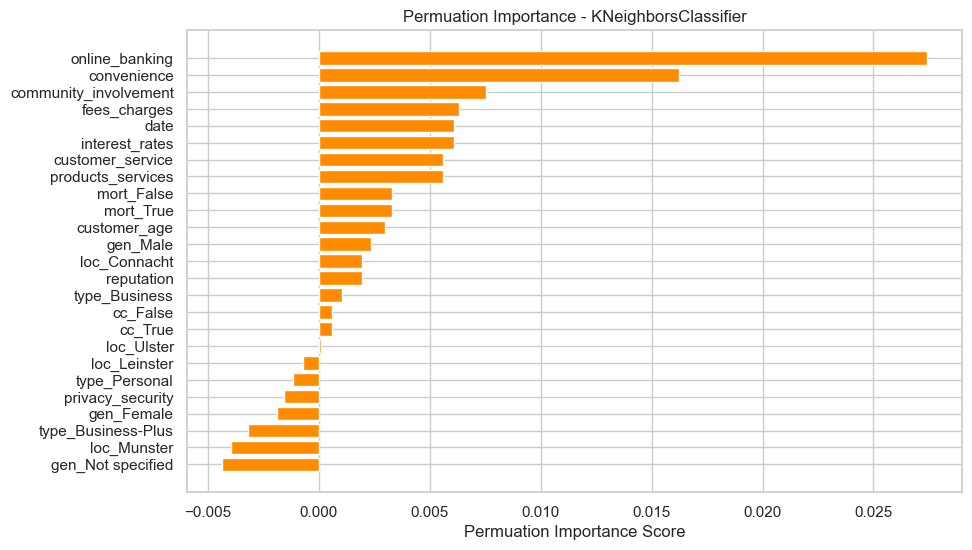

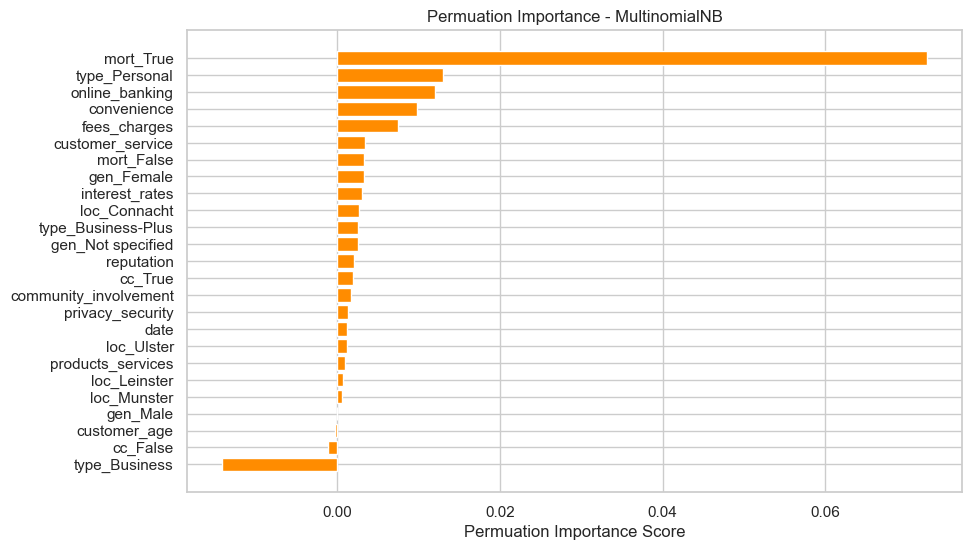

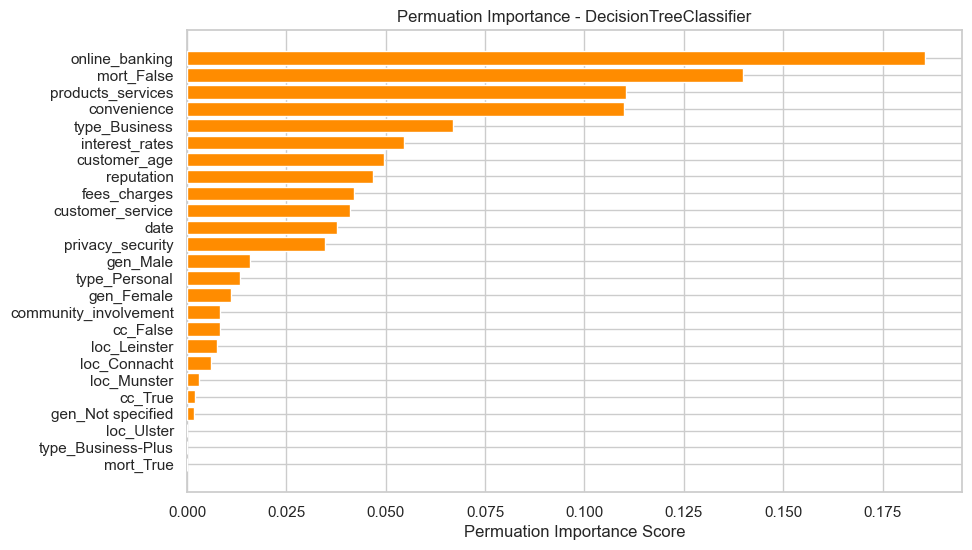

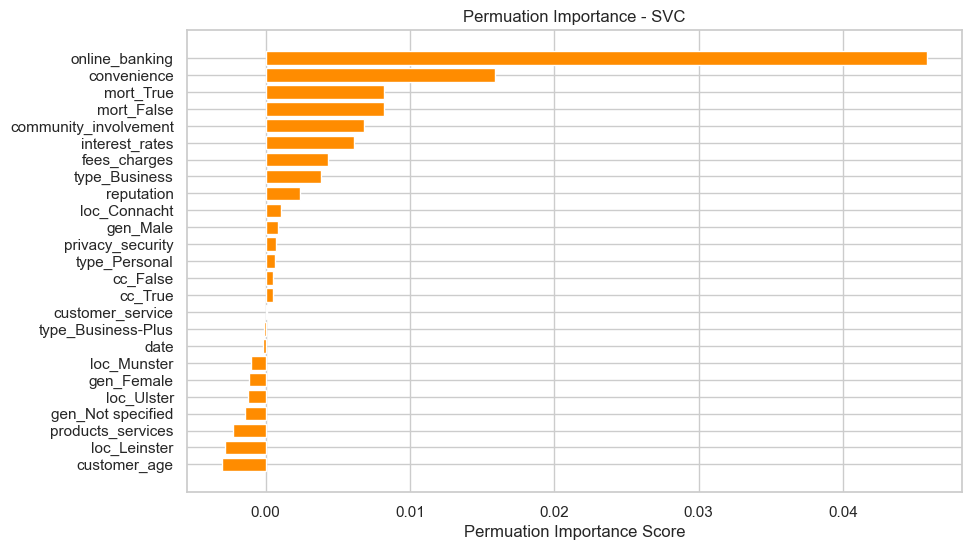

In [74]:
threshold = 10
importance_results_df, all_selected_features = run_feature_importance(data_train, target_train, threshold)
importance_results_df

In [75]:
importance_results_df

,Classifier,Mean CV Accuracy (%),Mean CV Precision (%),Mean CV Recall (%),Mean CV F1 Score (%),Selected Features
0,KNeighborsClassifier,82.01,82.11,82.01,80.97,"[online_banking, convenience, community_involv..."
1,MultinomialNB,76.32,77.59,76.32,75.97,"[mort_True, type_Personal, online_banking, con..."
2,DecisionTreeClassifier,82.32,82.56,82.32,81.72,"[online_banking, mort_False, products_services..."
3,SVC,84.59,84.62,84.59,83.87,"[online_banking, convenience, mort_True, mort_..."


The performace of all classifiers improved when compared with whole dataset.

The 10 most important features for KNeighbors Classifier is:

In [76]:
all_selected_features[0]

['online_banking',
 'convenience',
 'community_involvement',
 'fees_charges',
 'date',
 'interest_rates',
 'customer_service',
 'products_services',
 'mort_False',
 'mort_True']

The 10 most important features for MultinomialNB Classifier is:

In [77]:
all_selected_features[1]

['mort_True',
 'type_Personal',
 'online_banking',
 'convenience',
 'fees_charges',
 'customer_service',
 'mort_False',
 'gen_Female',
 'interest_rates',
 'loc_Connacht']

The 10 most important features for DecisionTree Classifier is:

In [78]:
all_selected_features[2]

['online_banking',
 'mort_False',
 'products_services',
 'convenience',
 'type_Business',
 'interest_rates',
 'customer_age',
 'reputation',
 'fees_charges',
 'customer_service']

The 10 most important features for SVC Classifier is:

In [79]:
all_selected_features[3]

['online_banking',
 'convenience',
 'mort_True',
 'mort_False',
 'community_involvement',
 'interest_rates',
 'fees_charges',
 'type_Business',
 'reputation',
 'loc_Connacht']

#### Information Gain Ranking

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

Calculate the 15 most informative features

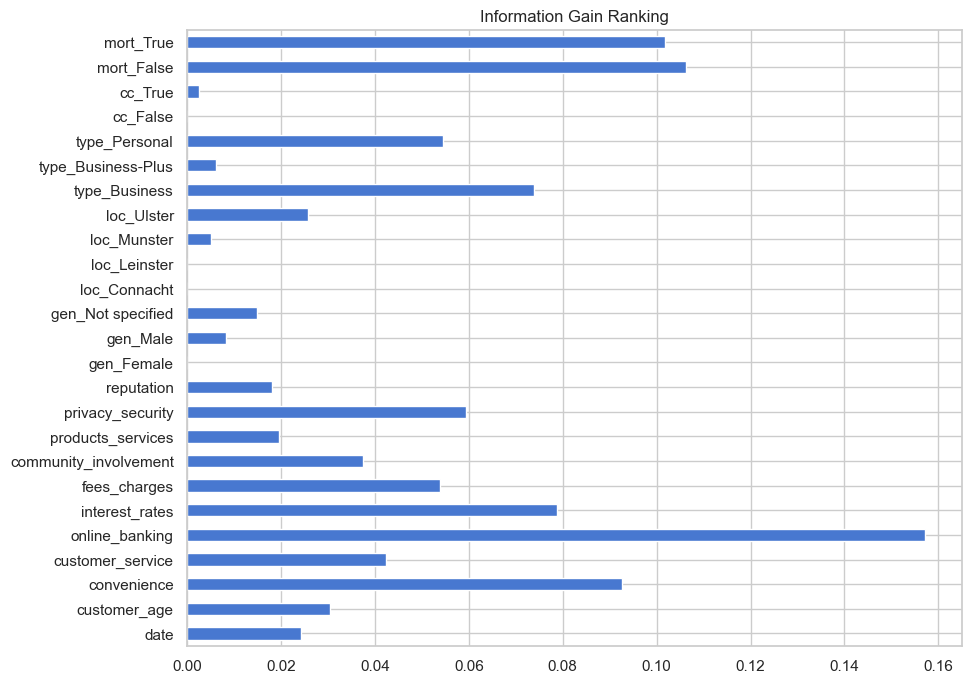

In [80]:
threshold = 15  # the number of most relevant features
important_features = []
feature_scores = mutual_info_classif(data_train, target_train)
important_feat = pd.Series(feature_scores, data_train.columns[0:len(data_train.columns)])
important_feat.plot(kind='barh', figsize=(10,8), title = "Information Gain Ranking")
plt.show()

for score, f_name in sorted(zip(feature_scores, data_train.columns), reverse=True)[:threshold]:
        #print(f_name, score)
        important_features.append(f_name)


Print the most informative features

In [81]:
pprint(important_features)

['online_banking',
 'mort_False',
 'mort_True',
 'convenience',
 'interest_rates',
 'type_Business',
 'privacy_security',
 'type_Personal',
 'fees_charges',
 'customer_service',
 'community_involvement',
 'customer_age',
 'loc_Ulster',
 'date',
 'products_services']


Create the igr_data dataframe to contain only the set of the features calculated by Information Gain Ranking

In [82]:
# Keep from train only the selected features
igr_data = data_train[important_features]
igr_data.shape

(967, 15)

Define the run_cross_validate function to evaluate a set of classifiers on the feature set prepared by Information Gain ranking process. The classification models are:
1. KNeighborsClassifier
2. MultinomialNB
3. DecisionTreeClassifier
4. SVC
Cross Validation is used to perform the evaluation.

During the model evaluation, the following evaluation measures are computed and reported:`accuracy`, `precision`, `recall` and `f1 score`. 

In [83]:
def run_cross_validate(data, target):
    # Create models

    models = [KNeighborsClassifier(n_neighbors=3), MultinomialNB(),
              DecisionTreeClassifier(), 
              RandomForestClassifier(n_estimators=1000, random_state=0),
              SVC(gamma='auto')]

    # Define custom scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='macro')
    }
    
    
    models_names = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    
    #for model, name in zip(models, names):
    for model in models:
        model_name = type(model).__name__
        print("Selecting features for classifier: ", model_name)
        
        model.fit(data, target)
        
        cross_val = cross_validate(model, data, target, cv=5, scoring=scoring)
        # compute mean values of all scoring metrics
        # overall average accuracy
        mean_accuracy = cross_val['test_accuracy'].mean()
        #print("Mean accuracy: %.4f" % mean_accuracy)
        accuracies.append(round(mean_accuracy*100, 2))
        
        # overall average precision
        mean_precision = cross_val['test_precision'].mean()
        precisions.append(round(mean_precision*100, 2))
        #print("Mean precision: %.4f" % mean_precision)
        
        # overall average recall
        mean_recall = cross_val['test_recall'].mean()
        recalls.append(round(mean_recall*100, 2))
        #print("Mean recall: %.4f" % mean_recall)
        
        # overall average F1 score
        mean_f1_score = cross_val['test_f1_score'].mean()
        #print("Mean F1 score: %.4f" % mean_f1_score)
        f1_scores.append(round(mean_f1_score*100, 2))
        
                       
        models_names.append(model_name)
        
    results = {
        "Classifier": models_names,
        "Mean CV Accuracy (%)": accuracies,
        "Mean CV Precision (%)": precisions,
        "Mean CV Recall (%)": recalls,
        "Mean CV F1 Score (%)": f1_scores,
    }

    results_df = pd.DataFrame(results)
    #results_df
    return  results_df

In [84]:
igr_results_df = run_cross_validate(igr_data, target_train)

Selecting features for classifier:  KNeighborsClassifier
Selecting features for classifier:  MultinomialNB
Selecting features for classifier:  DecisionTreeClassifier
Selecting features for classifier:  RandomForestClassifier
Selecting features for classifier:  SVC


In [85]:
igr_results_df

,Classifier,Mean CV Accuracy (%),Mean CV Precision (%),Mean CV Recall (%),Mean CV F1 Score (%)
0,KNeighborsClassifier,82.22,82.56,82.22,80.94
1,MultinomialNB,72.18,72.98,72.18,71.64
2,DecisionTreeClassifier,79.22,79.38,79.22,78.39
3,RandomForestClassifier,87.08,87.24,87.08,86.48
4,SVC,82.94,83.01,82.94,82.15


The performance of the MultinomialNB and SVC classifiers decreased when compared with the whole dataset. The reset two classifier performed better.

### Parameter optimization of best performing classifier

Find the model with the best performance and try to optimize its parameters.

Although, the best performing classifier is the Random Forest classifier, its parameter optimazation takes a long time to be executed and thus I select the KNN classifier to proceed the optimization of its parameters.

Let's find out the best k for KNN classifier.  

In [86]:
# Define a set of possible k values and  
num_est = [1,3,5,7,9,11]

Plot the validation curve to show how well the KNN model performs with different values of a k.

In [87]:
train_score, test_score = validation_curve(
                                KNeighborsClassifier(),
                                X = data_train, y = target_train, 
                                param_name = 'n_neighbors', 
                                param_range = num_est, cv = 5)

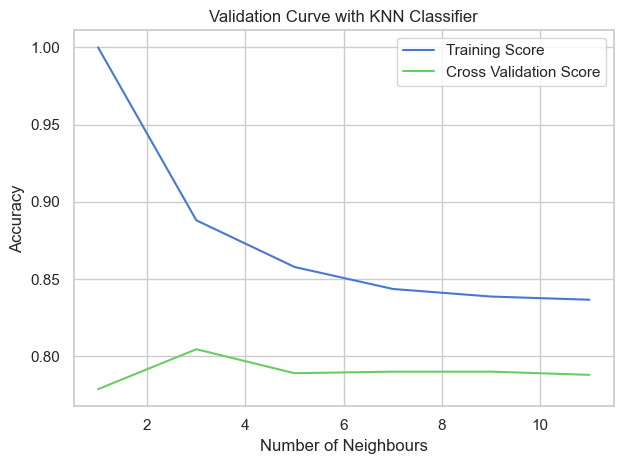

In [88]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(num_est, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(num_est, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

The best value for k appears to be 3

But, to find out the optimal values for a set of parameter of the KNN classifier, the GridSearchCV is used to conduct an exhaustive grid search. It takes a list of parameters and tries every single possible combination of these parameters as well as as many cross-validations as specified.

In [89]:
# grid searching key hyperparametres for KNeighborsClassifier

# define models and parameters
param_grid = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}
model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), cv = 5, param_grid=param_grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(data_train, target_train)

The optimal values of the parameters are:

In [90]:
print(grid_result.best_estimator_)

KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')


Build the KNN classifier with the best values, train it on the training dataset and evaluate it on the testing dataset.

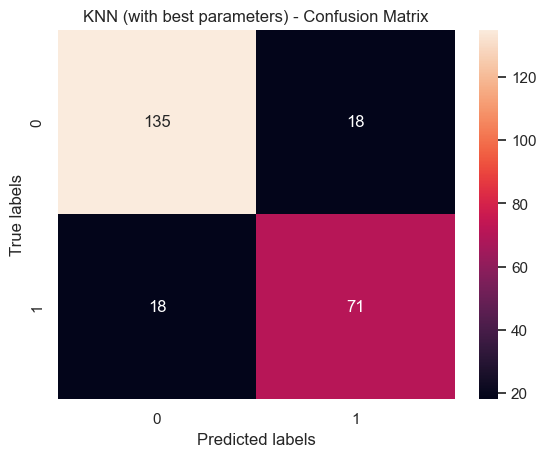

In [91]:
best_knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
                                   
best_knn_model = best_knn_model.fit(data_train, target_train)
y_pred = best_knn_model.predict(data_test)


conf_matrix = confusion_matrix(target_test, y_pred)
#print("Confusion matrix is: \n", conf_matrix)

plt.figure()
#annot=True to annotate cells, ftm='g' to disable scientific notation  
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title("KNN (with best parameters) - Confusion Matrix")
class_report = classification_report(target_test, y_pred, output_dict=True)

The evaluation results of the KNN model with best values on its parameters are:

In [92]:

print("Accuracy (%):", round(class_report["accuracy"]*100, 2))
print("Precision (%):", round(class_report["macro avg"]["precision"]*100, 2))
print("Recall (%):", round(class_report["macro avg"]["recall"]*100, 2))
print("F1 score (%):", round(class_report["macro avg"]["f1-score"]*100, 2))

Accuracy (%): 85.12
Precision (%): 84.01
Recall (%): 84.01
F1 score (%): 84.01


The accuracy improved to 85.12% from 79.75% (whole features and default parameters) and the precision also improved to 84.01% from 77.96%. 


In [93]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.88      0.88       153
        True       0.80      0.80      0.80        89

    accuracy                           0.85       242
   macro avg       0.84      0.84      0.84       242
weighted avg       0.85      0.85      0.85       242



In [94]:
# Better performance !!!

## Task 4 - Text Data Classification

Read the file that contains the customer comments

In [116]:
comments_df = pd.read_table(comments_file).set_index("customer_id")
print("Read %d customers' comments" % len(comments_df))
print("The dimensions of Comments data are: ", comments_df.shape)
comments_df.head(5)

Read 3000 customers' comments
The dimensions of Comments data are:  (3000, 2)


,date,comments
customer_id,,
216604,2022-08-22,"Overal, this bank is satisfactory."
259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...
265459,2022-01-21,Bank's phone app is really great. In general a...
58770,2022-03-13,NaN
318031,2022-08-08,NaN


Integrate text data with the existing tabular data

In [117]:
result = pd.concat([tabular_df, comments_df], axis=1)
result.shape

(3000, 19)

In [118]:
result.head(5)

,date,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied,date,comments
customer_id,,,,,,,,,,,,,,,,,,,
216604,2022-08-22,Male,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True,2022-08-22,"Overal, this bank is satisfactory."
259276,2022-11-23,Female,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...
265459,2022-01-21,Female,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,2.0,NaN,4.0,4.0,NaN,True,2022-01-21,Bank's phone app is really great. In general a...
58770,2022-03-13,Female,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True,2022-03-13,NaN
318031,2022-08-08,Female,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False,2022-08-08,NaN


Construct a dataframe that will only contain the comments and satisfied features

In [119]:
df = result[['comments','satisfied']]
print("The shape is: ", df.shape)
df.head(5)

The shape is:  (3000, 2)


,comments,satisfied
customer_id,,
216604,"Overal, this bank is satisfactory.",True
259276,Easy to find zhe bank ' s branches and ATMs. A...,True
265459,Bank's phone app is really great. In general a...,True
58770,NaN,True
318031,NaN,False


Check target balance

In [120]:
target = df["satisfied"]
target.value_counts()

False    1737
True     1263
Name: satisfied, dtype: int64

<Axes: >

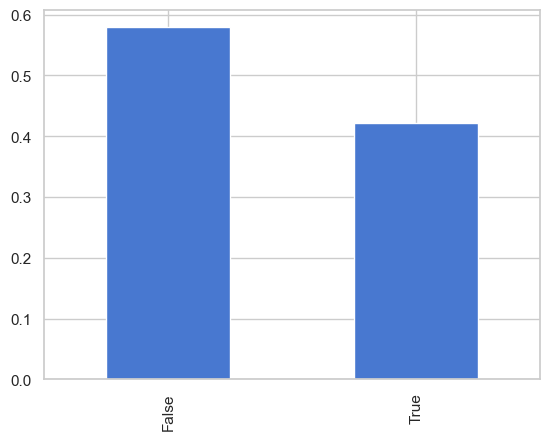

In [121]:
target.value_counts(normalize = True).plot.bar()

The dataset is balanced

### Text Data Preprocessing

Check for NULL or missing comments!

In [122]:
df['comments'].isnull().sum()

515

In [123]:
df['comments'].isna().sum()

515

clean the dataset from null values

In [124]:
df = df.dropna()
df.shape


(2485, 2)

Re-Check target balance after droping Nan values

In [125]:
target = df["satisfied"]
target.value_counts()

False    1433
True     1052
Name: satisfied, dtype: int64

<Axes: >

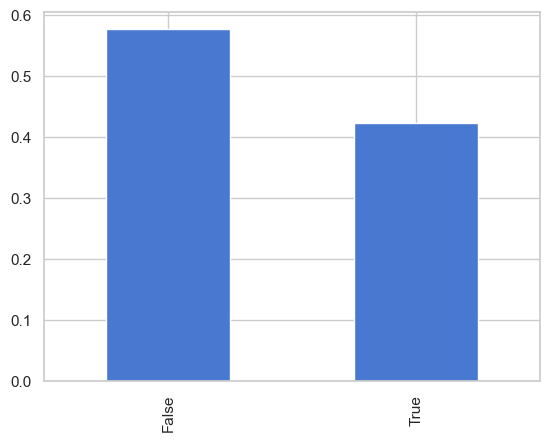

In [126]:
target.value_counts(normalize = True).plot.bar()

the dataset is still balanced

Text Cleaning: Remove punctuations & Extra Spaces 

In [127]:
# Remove punctuations

In [128]:
df['comments'] = df['comments'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))

In [129]:
# Remove Remove Extra Spaces

In [130]:
df['comments'] = df['comments'].apply(lambda x: re.sub(' +', ' ', x))

Create a vector representations of the documents. 

Define the lemma_tokenizer function to lemmatize the tokens

In [131]:
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token))
    return lemma_tokens

As lemmatization is applied to texts, it should also be applied to stopwords

In [134]:
# apply lemmatization to  English stopwords
stopwords = text.ENGLISH_STOP_WORDS
lemma_stopwords = []
lemmatizer = WordNetLemmatizer()
for stopword in stopwords:
     lemma_stopwords.append(lemmatizer.lemmatize(stopword))

Apply to corpus the following pre-processing:
1. Case conversion (by default)
2. Minimum term length - exclude terms with length < 2 by default
3. Stop-word filtering
4. Low frequency filtering - remove terms that appear in less than 3 documents
5. Lemmatizing - Reduce term to each canonical form

Define four (4) vectorization types:
1. Bag-of-words (Count) vector (implemented by CountVectorizer) 
2. Count vector with N-grams
3. TF-IDF weighting vector (implemeneted by TfidfVectorizer)
4. TF-IDF vector with N-grams

For each vectorization type, a relevant document-term matrix will be created.

In [150]:
# Bag-of-words (Count) vector 
vectorizer = CountVectorizer(stop_words=lemma_stopwords, min_df = 3, tokenizer=lemma_tokenizer)

count_X = vectorizer.fit_transform(df["comments"])
# check the size of the resulting representation
print(count_X.shape)

(2485, 520)


Display the 10 most frequent terms from bag-of-words (count) vector

In [151]:
# Display the 10 most frequent terms

freqs = zip(vectorizer.get_feature_names_out(), np.asarray(count_X.sum(axis=0)).ravel())
# sort from largest to smallest
sorted_freqs = sorted(freqs, key=lambda x: -x[1])
print(sorted_freqs[:10])


[('bank', 1986), ('service', 952), ('customer', 412), ('overall', 368), ('good', 337), ('need', 331), ('really', 290), ('banking', 288), ('rate', 284), ('provided', 264)]


In [152]:
# Bag-of-words (Count) vector with ngram (1,2)
vectorizer = CountVectorizer(stop_words=lemma_stopwords, min_df = 3, tokenizer=lemma_tokenizer, ngram_range=(1,2))

count_with_ngrams_X = vectorizer.fit_transform(df["comments"])
# check the size of the resulting representation
print(count_with_ngrams_X.shape)

(2485, 1603)


In [153]:
# TF-IDF vector 
vectorizer = TfidfVectorizer(stop_words=lemma_stopwords, min_df = 3, tokenizer=lemma_tokenizer)

tfidf_X = vectorizer.fit_transform(df["comments"])
# check the size of the resulting representation
print(tfidf_X.shape)

(2485, 520)


In [155]:
### Display the 10 highest weighted terms
feature_array = np.array(vectorizer.get_feature_names_out())
tfidf_sorting = np.argsort(tfidf_X.toarray()).flatten()[::-1]

n = 10
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

['acceptabe' 'platform' 'impressive' 'general' 'online' 'really' 'bank'
 'experience' 'extensive' 'experienced']


In [156]:
# TF-IDF vector  with ngram (1,2)
vectorizer = TfidfVectorizer(stop_words=lemma_stopwords, min_df = 3, tokenizer=lemma_tokenizer, ngram_range=(1,2))

tfidf_with_ngrams_X = vectorizer.fit_transform(df["comments"])
# check the size of the resulting representation
print(tfidf_with_ngrams_X.shape)

(2485, 1603)


### Text Classification

For each defined vector, make a train/test split, so that we have 90% of the comments in the training set and 10% in the test set.

In [159]:
# Bag-of-words (Count) vector
# Split the dataset (comments+labels) to create training set (90%) and testing set (10%)
count_X_train, count_X_test, count_target_train, count_target_test = train_test_split(count_X, target, test_size=0.1, random_state=1)
# Check the shapes of training/testing datasets
print("Vector count - Training dataset size:" , count_X_train.shape)
print("Vector count - Testing dataset size:" , count_X_test.shape)

Vector count - Training dataset size: (2236, 520)
Vector count - Testing dataset size: (249, 520)


In [160]:
# Bag-of-words (Count) vector with ngrams
# Split the dataset (comments+labels) to create training set (90%) and testing set (10%)
count_with_ngrams_X_train, count_with_ngrams_X_test, count_with_ngrams_target_train, count_with_ngrams_target_test = train_test_split(count_with_ngrams_X, target, test_size=0.1, random_state=1)
# Check the shapes of training/testing datasets
print("Vector count - Training dataset size:" , count_with_ngrams_X_train.shape)
print("Vector count - Testing dataset size:" , count_with_ngrams_X_test.shape)

Vector count - Training dataset size: (2236, 1603)
Vector count - Testing dataset size: (249, 1603)


In [161]:
# TF-IDF vector 
# Split the dataset (comments+labels) to create training set (90%) and testing set (10%)
tfidf_X_train, tfidf_X_test, tfidf_target_train, tfidf_target_test = train_test_split(tfidf_X, target, test_size=0.1, random_state=1)
# Check the shapes of training/testing datasets
print("Vector count - Training dataset size:" , tfidf_X_train.shape)
print("Vector count - Testing dataset size:" , tfidf_target_train.shape)

Vector count - Training dataset size: (2236, 520)
Vector count - Testing dataset size: (2236,)


In [162]:
# TF-IDF vector with ngrams
# Split the dataset (comments+labels) to create training set (90%) and testing set (10%)
tfidf_with_ngrams_X_train, tfidf_with_ngrams_X_test, tfidf_with_ngrams_target_train, tfidf_with_ngrams_target_test = train_test_split(tfidf_with_ngrams_X, target, test_size=0.1, random_state=1)
# Check the shapes of training/testing datasets
print("Vector count - Training dataset size:" , tfidf_with_ngrams_X_train.shape)
print("Vector count - Testing dataset size:" , tfidf_with_ngrams_X_test.shape)

Vector count - Training dataset size: (2236, 1603)
Vector count - Testing dataset size: (249, 1603)


Use **cross-validation** to evaluate the classifiers on the training set. 

The following classifier will be trained: 
* LogisticRegression
* KNeighborsClassifier, k=3
* MultinomialNB
* DecisionTreeClassifier
* SVC
* RandomForestClassifier(n_estimators=1000)

Define run_text_validation_models() function to evaluate with cross validation the predefined set of classifiers.
During the model evaluation, the following evaluation measures are computed and reported:`accuracy`, `precision`, `recall` and `f1 score`. In addition the confution matrix is calculated and visualized

In [170]:
def run_text_validation_models(X_train, y_train):
    # Create models
    models = [LogisticRegression(), KNeighborsClassifier(n_neighbors=3), MultinomialNB(), 
              DecisionTreeClassifier(), SVC(), RandomForestClassifier(n_estimators=1000, random_state=0)]

    # Define custom scoring metrics

    # Refer to paragraph 3.3.1.4 of https://scikit-learn.org/stable/modules/model_evaluation.html#scoring        
    def confusion_matrix_scorer(clf, X, y):
        y_pred = clf.predict(X)
        cm = confusion_matrix(y, y_pred)
        #print(cm)
        return {'tp': cm[0, 0], 'fp': cm[0, 1],
                'fn': cm[1, 0], 'tn': cm[1, 1]}
    
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='macro'),
    }
    
    models_results = {}
    models_names = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    tps = []
    fps = []
    fns = []
    tns = []
       
    fig, axes = plt.subplots(nrows=1, ncols=6)
    fig.set_figheight(5)
    fig.set_figwidth(30)
    
    i=0
    for model in models:
        
        model_results = {}
        
        # Perform 5-fold cross-validation with custom scoring metrics
        model_name = type(model).__name__
        pprint(model_name)

        cross_val = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
        #pprint(cross_val)
        
        cross_val_cnfm = cross_validate(model, X_train, y_train, cv=5, scoring=confusion_matrix_scorer)
        #print(cross_val_cnfm['test_tp'])
        mean_tps = cross_val_cnfm['test_tp'].mean()
        tps.append(mean_tps)
        #print(cross_val_cnfm['test_fp'])
        mean_fps = cross_val_cnfm['test_fp'].mean()
        fps.append(mean_fps)
        #print(cross_val_cnfm['test_fn'])
        mean_fns = cross_val_cnfm['test_fn'].mean()
        fns.append(mean_fns)
        #print(cross_val_cnfm['test_tn'])
        mean_tns = cross_val_cnfm['test_tn'].mean()
        tns.append(mean_tns)  
        
        conf_matrix = np.array([[mean_tps, mean_fps], [mean_fns, mean_tns]])        
   
        plt.figure()
        #annot=True to annotate cells, ftm='g' to disable scientific notation  
        sns.heatmap(conf_matrix, annot=True, fmt='g', ax=axes[i])
        # labels, title and ticks
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
        plot_title = 'Confusion Matrix - '+ model_name
        axes[i].set_title(plot_title)
        i = i+1
        models_results[model_name] = cross_val

        # compute mean values of all scoring metrics
        # overall average accuracy
        mean_accuracy = cross_val['test_accuracy'].mean()
        #print("Mean accuracy: %.4f" % mean_accuracy)
        accuracies.append(round(mean_accuracy*100, 2))
        
        # overall average precision
        mean_precision = cross_val['test_precision'].mean()
        precisions.append(round(mean_precision*100, 2))
        #print("Mean precision: %.4f" % mean_precision)
        
        # overall average recall
        mean_recall = cross_val['test_recall'].mean()
        recalls.append(round(mean_recall*100, 2))
        #print("Mean recall: %.4f" % mean_recall)
        
        # overall average F1 score
        mean_f1_score = cross_val['test_f1_score'].mean()
        #print("Mean F1 score: %.4f" % mean_f1_score)
        f1_scores.append(round(mean_f1_score*100, 2))
                       
        models_names.append(model_name)
    
    results = {
        "Classifier": models_names,
        "Mean Accuracy (%)": accuracies,
        "Mean Precision (%)": precisions,
        "Mean Recall (%)": recalls,
        "Mean F1 Score (%)": f1_scores,
        "Mean No of TP": tps,
        "Mean No of FN": fns,
        "Mean No of FP": fps,
        "Mean No of TN": tns,
    }

    results_df = pd.DataFrame(results)
    #results_df
    return models_results, results_df

Train the classifiers with **Bag-of-words (Count) vector** 

'LogisticRegression'
'KNeighborsClassifier'
'MultinomialNB'
'DecisionTreeClassifier'
'SVC'
'RandomForestClassifier'


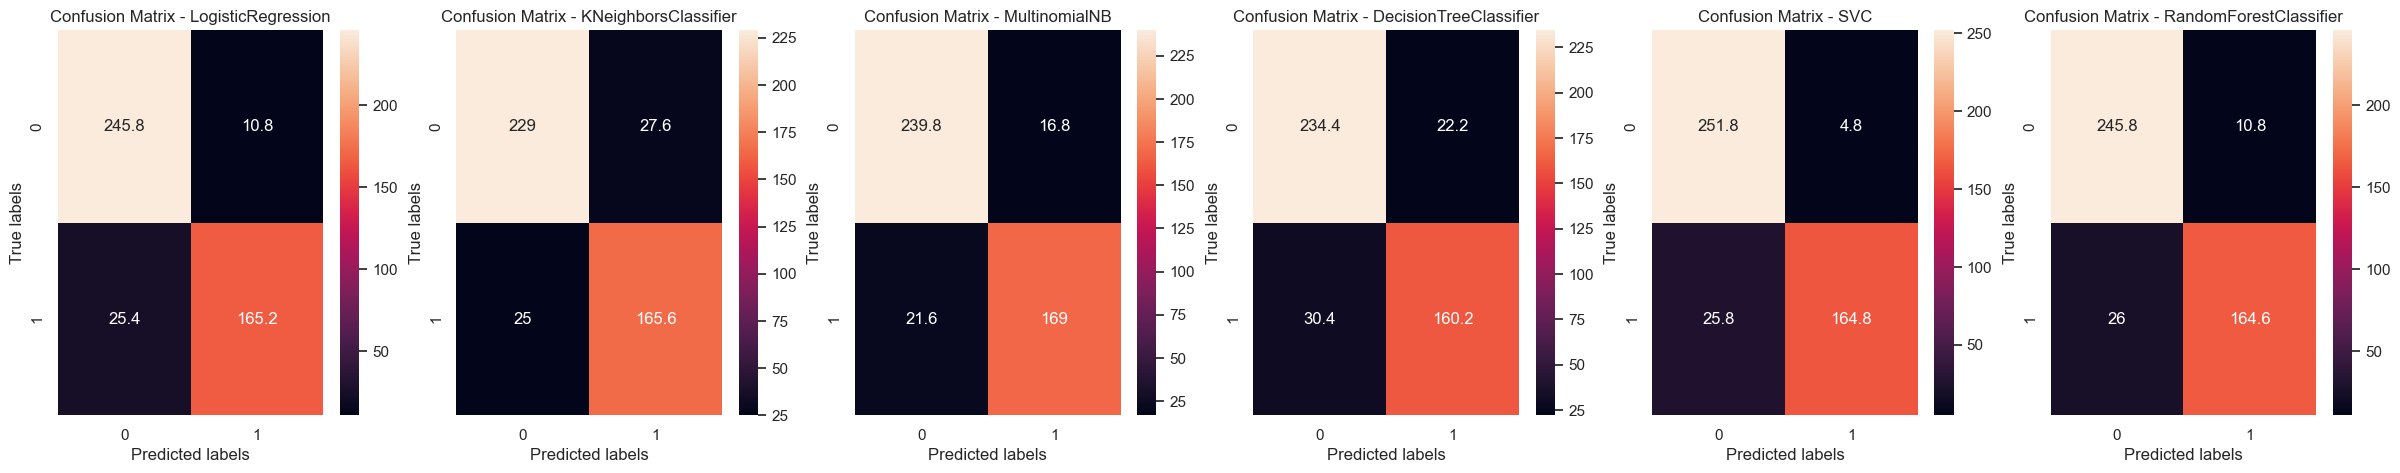

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [171]:
count_models_results, count_results_df = run_text_validation_models(count_X_train, count_target_train)

In [172]:
count_results_df

,Classifier,Mean Accuracy (%),Mean Precision (%),Mean Recall (%),Mean F1 Score (%),Mean No of TP,Mean No of FN,Mean No of FP,Mean No of TN
0,LogisticRegression,91.91,92.26,91.91,91.62,245.8,25.4,10.8,165.2
1,KNeighborsClassifier,88.24,88.54,88.24,87.98,229.0,25.0,27.6,165.6
2,MultinomialNB,91.41,91.64,91.41,91.18,239.8,21.6,16.8,169.0
3,DecisionTreeClassifier,88.46,88.61,88.46,88.10,234.4,30.4,22.2,160.2
4,SVC,93.16,93.48,93.16,92.88,251.8,25.8,4.8,164.8
5,RandomForestClassifier,91.77,92.16,91.77,91.47,245.8,26.0,10.8,164.6


SVG has the best Accuracy(93.16%) and best F1-score(92.88%), although the number of false negatives(25.8) that it computes is not the lower. The minimum of the false negatives(21.6) is computed by multinomialNB. The minimum false positives(4.8) is reported by SVC. The maximum true positives(251.8) is computed by SVC. All clasifiers have approximately the same true negatives.

Train the classifiers with **Bag-of-words (Count) vector and ngrams = (1,2)** 

'LogisticRegression'
'KNeighborsClassifier'
'MultinomialNB'
'DecisionTreeClassifier'
'SVC'
'RandomForestClassifier'


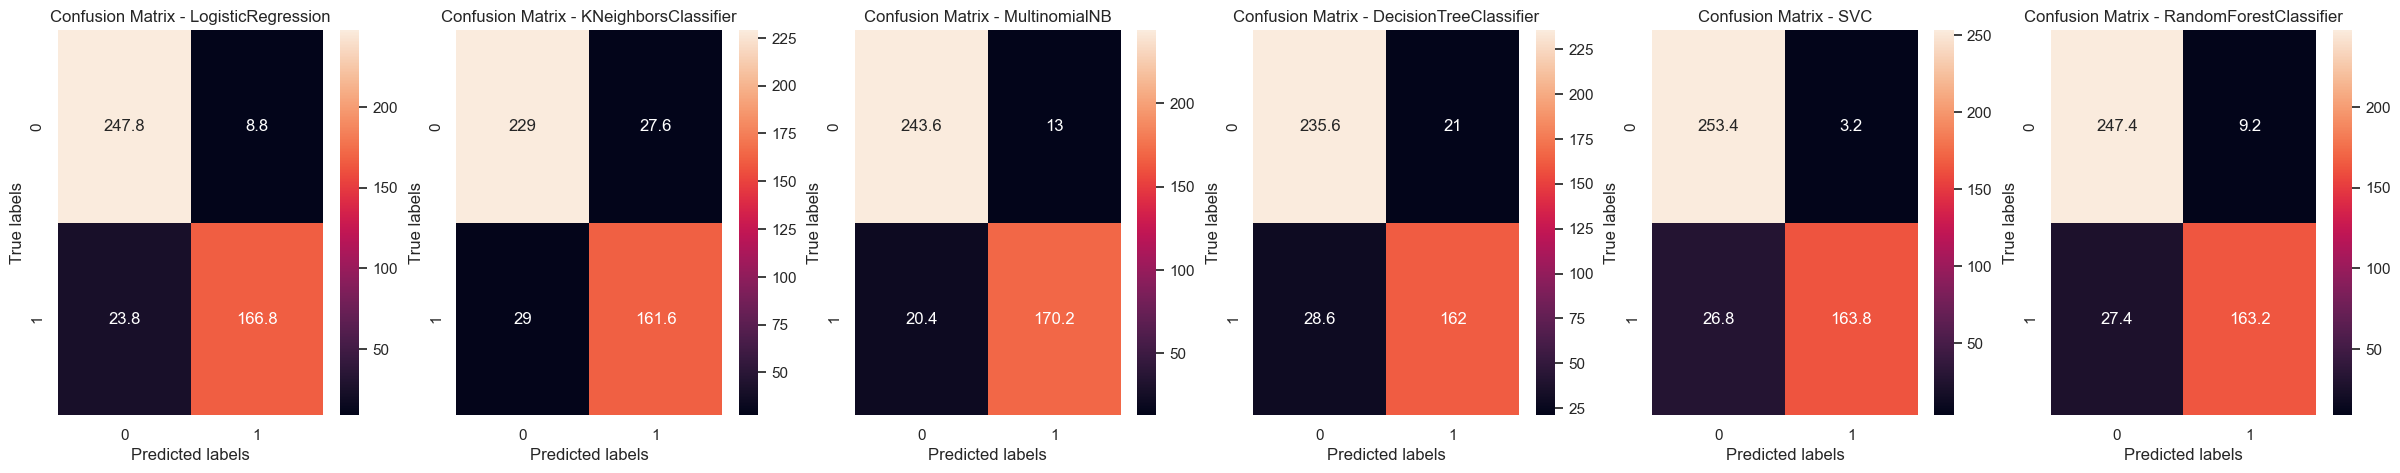

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [173]:
count_with_ngrams_models_results, count_with_ngrams__results_df = run_text_validation_models(count_with_ngrams_X_train, count_with_ngrams_target_train)


In [174]:
count_with_ngrams__results_df

,Classifier,Mean Accuracy (%),Mean Precision (%),Mean Recall (%),Mean F1 Score (%),Mean No of TP,Mean No of FN,Mean No of FP,Mean No of TN
0,LogisticRegression,92.71,93.08,92.71,92.45,247.8,23.8,8.8,166.8
1,KNeighborsClassifier,87.34,87.59,87.34,87.01,229.0,29.0,27.6,161.6
2,MultinomialNB,92.53,92.76,92.53,92.32,243.6,20.4,13.0,170.2
3,DecisionTreeClassifier,88.15,88.26,88.15,87.79,235.6,28.6,21.0,162.0
4,SVC,93.29,93.72,93.29,93.00,253.4,26.8,3.2,163.8
5,RandomForestClassifier,91.82,92.31,91.82,91.50,247.4,27.4,9.2,163.2


SVG has the best Accuracy(93.26%) and best F1-score(93).The number of false negatives(26.8) that it computes is not the lower. The minimum of the false negatives(20.4) is computed by multinomialNB. The minimum false positives(3.2) is reported by SVC. The maximum true positives(253.4) is computed by SVC. The maximum true negative(170.2) is reported by multinomialNB

Train the classifiers with **TD-IDF vector** 

'LogisticRegression'
'KNeighborsClassifier'
'MultinomialNB'
'DecisionTreeClassifier'
'SVC'
'RandomForestClassifier'


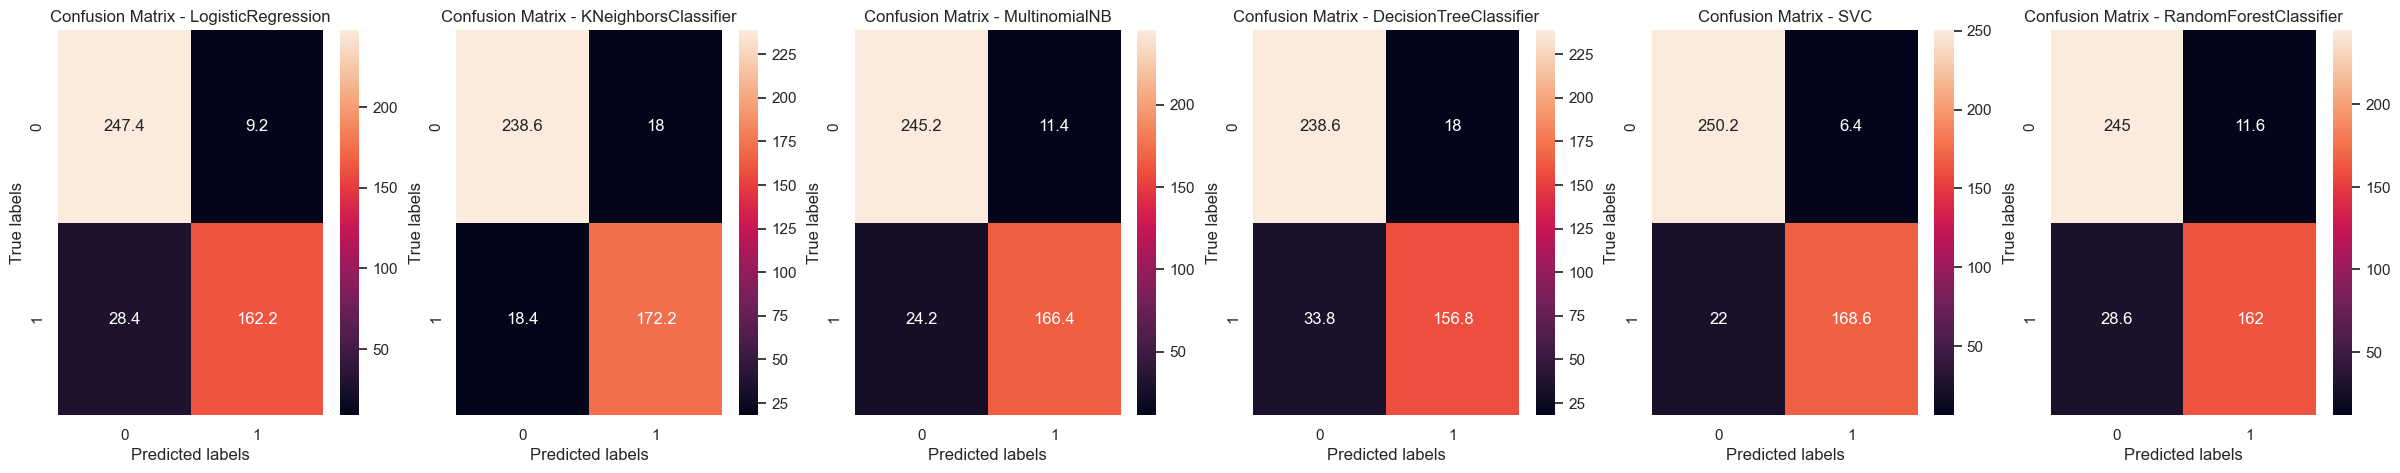

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [175]:
tfidf_models_results, tfidf_results_df = run_text_validation_models(tfidf_X_train,  tfidf_target_train)

In [176]:
tfidf_results_df

,Classifier,Mean Accuracy (%),Mean Precision (%),Mean Recall (%),Mean F1 Score (%),Mean No of TP,Mean No of FN,Mean No of FP,Mean No of TN
0,LogisticRegression,91.59,92.12,91.59,91.25,247.4,28.4,9.2,162.2
1,KNeighborsClassifier,91.86,92.25,91.86,91.65,238.6,18.4,18.0,172.2
2,MultinomialNB,92.04,92.33,92.04,91.77,245.2,24.2,11.4,166.4
3,DecisionTreeClassifier,88.82,89.06,88.82,88.41,238.6,33.8,18.0,156.8
4,SVC,93.65,94.07,93.65,93.42,250.2,22.0,6.4,168.6
5,RandomForestClassifier,91.01,91.39,91.01,90.67,245.0,28.6,11.6,162.0


SVG has the best Accuracy(93.65%) and best F1-score(93.43%).The number of false negatives(22) that it computes is not the lower. The minimum of the false negatives(18.4) is computed by KNN. The minimum false positives(6.4) is reported by SVC. The maximum true positives(250.2) is computed by SVC. The maximum true negative(172.2) is reported by KNN.

Train the classifiers with **TF-IDF vector with ngrams=(1,2)** 

'LogisticRegression'
'KNeighborsClassifier'
'MultinomialNB'
'DecisionTreeClassifier'
'SVC'
'RandomForestClassifier'


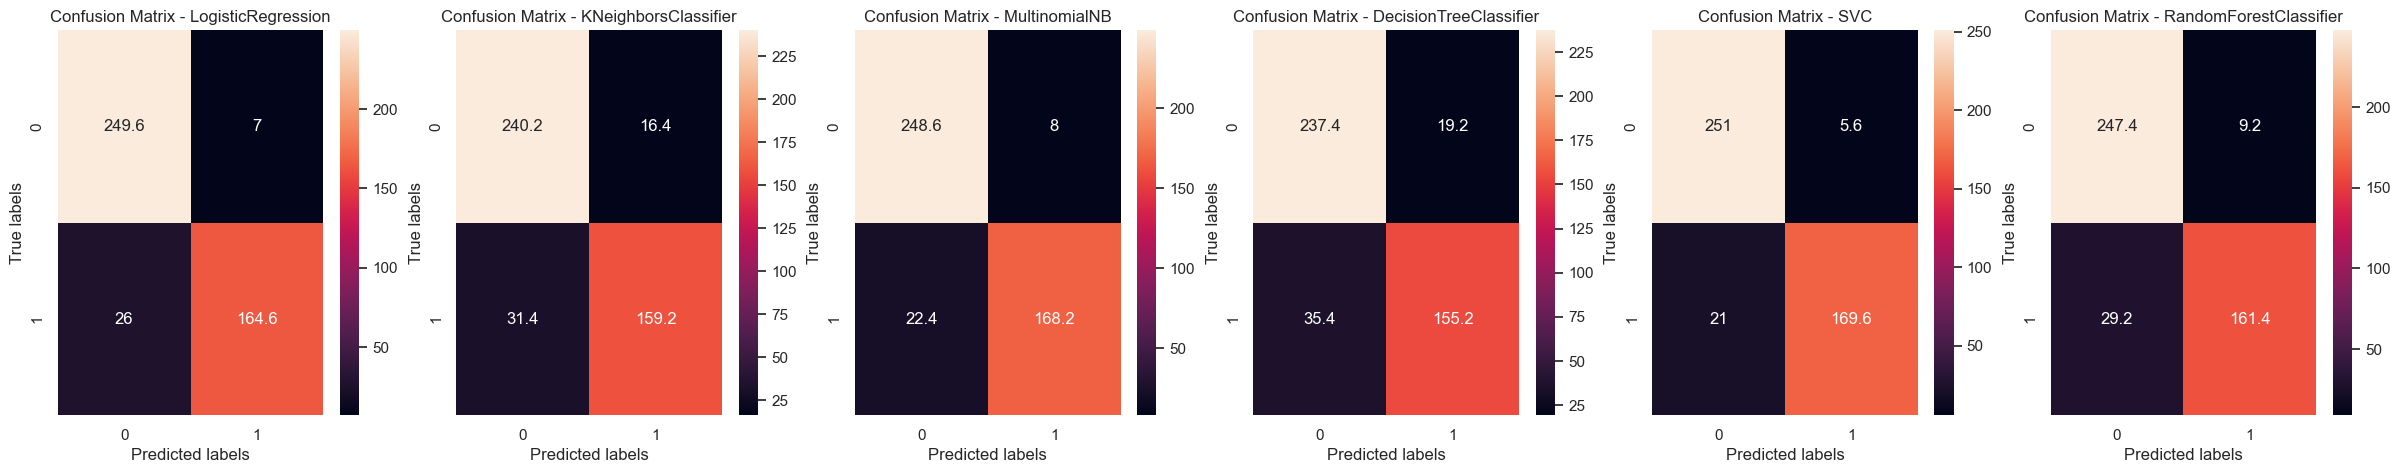

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [177]:
tfidf_with_ngrams_models_results, tfidf_with_ngrams__results_df = run_text_validation_models(tfidf_with_ngrams_X_train, tfidf_with_ngrams_target_train)

In [178]:
tfidf_with_ngrams__results_df

,Classifier,Mean Accuracy (%),Mean Precision (%),Mean Recall (%),Mean F1 Score (%),Mean No of TP,Mean No of FN,Mean No of FP,Mean No of TN
0,LogisticRegression,92.62,93.13,92.62,92.32,249.6,26.0,7.0,164.6
1,KNeighborsClassifier,89.31,89.92,89.31,88.84,240.2,31.4,16.4,159.2
2,MultinomialNB,93.20,93.57,93.20,92.97,248.6,22.4,8.0,168.2
3,DecisionTreeClassifier,87.52,87.73,87.52,87.06,237.4,35.4,19.2,155.2
4,SVC,94.05,94.46,94.05,93.84,251.0,21.0,5.6,169.6
5,RandomForestClassifier,91.41,91.92,91.41,91.07,247.4,29.2,9.2,161.4


SVG has the best Accuracy(94.05%) and best F1-score(93.74%).The number of false negatives(21) that it computes is the lower. The minimum false positives(5.6) is reported by SVC. The maximum true positives(251) is computed by SVC. The maximum true negative(169.6) is reported by SVC.

Therefore, SVC performs better with all datasets. Try to fine tune its parameters (in each dataset).
Define fine_tune() function that defines a parameter search grid and calls the GridSearchCV function to conduct an exhaustive grid search (tries every single combination of parameters) by running cross validation. Finaly it builds an SVC model with the best parameters found, trains it in the training dataset and evaluates it in the testing dataset.
It reports the following evaluation measures: Accuracy, Precission, Recall and F1-score.

In [181]:
def fine_tune(X_train, X_test, target_train, target_test, dataset):
    # defining parameter range
    
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
    '''
    param_grid = {'C': [0.1], 
                  'gamma': [1],
                  'kernel': ['rbf']}
    '''
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, refit = True)

    # fitting the model for grid search
    grid_result = grid_search.fit(X_train, target_train)

    # summarize results
    #print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    best_params = grid_result.best_params_
    #print(best_params)
    
    best_model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])
                                   
    best_model = best_model.fit(X_train, target_train)
    
    y_pred = best_model.predict(X_test)

    conf_matrix = confusion_matrix(target_test, y_pred)
    #print("Confusion matrix is: \n", conf_matrix)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    class_report = classification_report(target_test, y_pred, output_dict=True)
    #print(class_report)

    '''
    print("Accuracy %:", round(class_report["accuracy"]*100, 2))
    print("Precision %:", round(class_report["macro avg"]["precision"]*100, 2))
    print("Recall %:", round(class_report["macro avg"]["recall"]*100, 2))
    print("F1 score %:", round(class_report["macro avg"]["f1-score"]*100, 2))
    '''
    results = {
        "Classifier": ["SVC with " + dataset],
        "Precision (%)": [round(class_report["macro avg"]["recall"]*100, 2)],
        "Recall (%)": [round(class_report["macro avg"]["recall"]*100, 2)],
        "Accuracy (%)": [round(class_report["accuracy"]*100, 2)],
        "F1 Score (%)": [round(class_report["macro avg"]["f1-score"]*100, 2)],
    }
    #print(results)

    results_df = pd.DataFrame(results)

    print(classification_report(target_test, y_pred))
    return best_params, results_df

Fine tune SVC with Bag-of-words (Count) vector, train and evaluate the model.

              precision    recall  f1-score   support

       False       0.93      0.99      0.96       150
        True       0.99      0.88      0.93        99

    accuracy                           0.95       249
   macro avg       0.96      0.94      0.94       249
weighted avg       0.95      0.95      0.95       249

Best parameters are:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


,Classifier,Precision (%),Recall (%),Accuracy (%),F1 Score (%)
0,SVC with bag-of-words,93.61,93.61,94.78,94.43


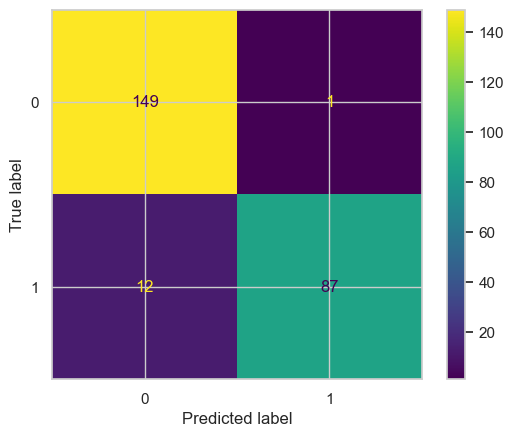

In [182]:
count_best_params, count_results_df = fine_tune(count_X_train, count_X_test, count_target_train, count_target_test, "bag-of-words")
print("Best parameters are: ", count_best_params)
count_results_df

The best parameters for Bag-of-words (Count) vector are:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} 

Fine tune SVC with Bag-of-words (Count) and ngrams = (1,2) vector , train and evaluate the model.

              precision    recall  f1-score   support

       False       0.93      0.99      0.96       150
        True       0.99      0.88      0.93        99

    accuracy                           0.95       249
   macro avg       0.96      0.94      0.94       249
weighted avg       0.95      0.95      0.95       249

Best parameters are:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


,Classifier,Precision (%),Recall (%),Accuracy (%),F1 Score (%)
0,"SVC with bag-of-words and ngrams=(1,2)",93.61,93.61,94.78,94.43


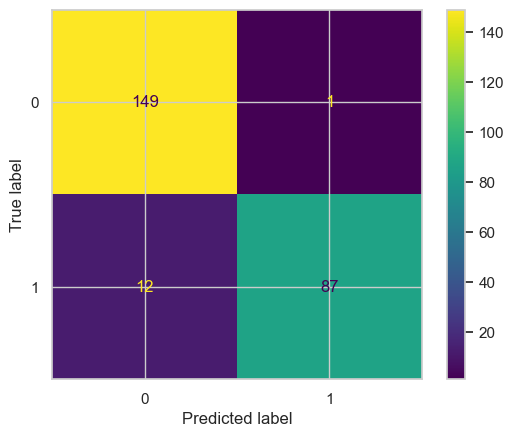

In [183]:
count_ngrams_best_params, count_ngrams_results_df = fine_tune(count_with_ngrams_X_train, count_with_ngrams_X_test, count_with_ngrams_target_train, count_with_ngrams_target_test, "bag-of-words and ngrams=(1,2)")
print("Best parameters are: ", count_ngrams_best_params)
count_ngrams_results_df

The best parameters for Bag-of-words (Count) and ngrams = (1,2) vector are:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

Fine tune SVC with TD-IDF vector, train and evaluate the model.

              precision    recall  f1-score   support

       False       0.94      1.00      0.97       150
        True       1.00      0.91      0.95        99

    accuracy                           0.96       249
   macro avg       0.97      0.95      0.96       249
weighted avg       0.97      0.96      0.96       249

Best parameters are:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


,Classifier,Precision (%),Recall (%),Accuracy (%),F1 Score (%)
0,SVC with TD-IDF,95.45,95.45,96.39,96.16


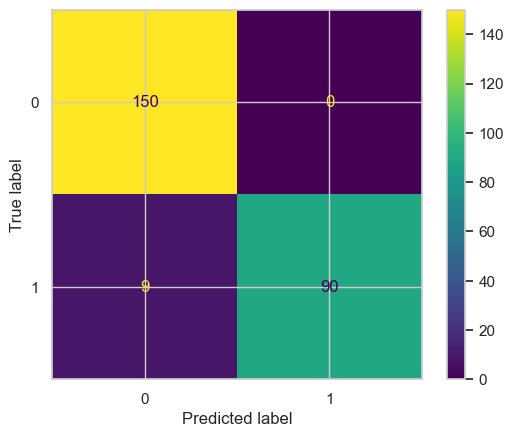

In [184]:
tdidf_best_params, tdidf_results_df = fine_tune(tfidf_X_train, tfidf_X_test, tfidf_target_train, tfidf_target_test, "TD-IDF")
print("Best parameters are: ", tdidf_best_params)
tdidf_results_df

The best parameters for TD-IDF vector vector are: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Fine tune SVC with TF-IDF vector with ngrams=(1,2) vector, train and evaluate the model.

              precision    recall  f1-score   support

       False       0.96      1.00      0.98       150
        True       1.00      0.93      0.96        99

    accuracy                           0.97       249
   macro avg       0.98      0.96      0.97       249
weighted avg       0.97      0.97      0.97       249

Best parameters are:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


,Classifier,Precision (%),Recall (%),Accuracy (%),F1 Score (%)
0,"SVC with TF-IDF and ngrams=(1,2)",96.46,96.46,97.19,97.03


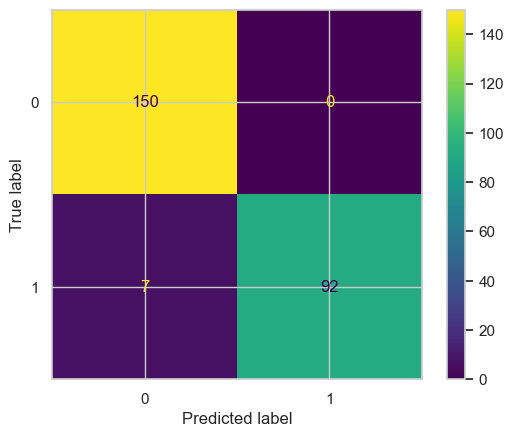

In [185]:
tdidf_ngrams_best_params, tdidf_ngrams_results_df = fine_tune(tfidf_with_ngrams_X_train, tfidf_with_ngrams_X_test, tfidf_with_ngrams_target_train, tfidf_with_ngrams_target_test, "TF-IDF and ngrams=(1,2)")
print("Best parameters are: ", tdidf_ngrams_best_params)
tdidf_ngrams_results_df

The best parameters for TD-IDF vector and ngrams = (1,2) vector are: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

The evaluation results after tuning of parameters and train & evaluation of the models with the best parameters are:

In [186]:
results = pd.concat([count_results_df, count_ngrams_results_df, tdidf_results_df, tdidf_ngrams_results_df], axis=0)
results

,Classifier,Precision (%),Recall (%),Accuracy (%),F1 Score (%)
0,SVC with bag-of-words,93.61,93.61,94.78,94.43
0,"SVC with bag-of-words and ngrams=(1,2)",93.61,93.61,94.78,94.43
0,SVC with TD-IDF,95.45,95.45,96.39,96.16
0,"SVC with TF-IDF and ngrams=(1,2)",96.46,96.46,97.19,97.03


All classifiers improved their performance when compared with prior fit. Maximum improvement reported by SVC classifier that trained with TD-IDF vector or TD-IDF vector with ngrams = (1,2). The first classifier improved its accuracy from 93.65% to 95.65% and its F1-score from 93.42% to 96.16%. The latter classifier improved its accuracy from 94.05% to 96.46% and its F1-score from 93.84% to 97.03%.

Best performance reported by SVC with TF-IDF and ngrams=(1,2) classifier.

## Task 5 - Conclusions

For tabular data representation a set of classifiers evaluated on all features. The random forest classifier had the best performance(accuracy = 88.84% and F1-score = 87.89%). Feature selection processes run to find out a set of best features for each classifier. The randomforest classifier excluded as it takes too long to execute. In the backward and forward feature selection the KNN and decision tree classifiers improved their performance when compared with the whole dataset. In permutation importance feature selection process all classifiers improved their performance while in the information gain ranking process improved performance was reported by multinomialNB and SVC classifiers.

KNN classifier was selected for fine tuning of its parameters and then based on the set of the optimal parameters a KNN classifier was build, trained and evaluated. This model improved its accuracy from 79.75% when compared with whole features and default parameters to 85.12%. Its pressition improved from 77.96% to 84.01%.

For test data representation 4 different vectorising types used: Bag-of-words(count) vector, Bag-of-words(count) vector with ngrams = (1,2), TD-IDF vector and TD-IDF with ngrams = (1,2).

The usage of TD-IDF vector with ngrams = (1,2) had as result the best performance. SVC model best performed among several tested classifiers. When it was build with a set of optimal parameters improved its accuracy from 94.05% to 96.46% and its F1-score from 93.84% to 97.03%.

To conclude, with this analysis i had the oportunity to deal with challenging aspects of machine learning such as feature selection processes, fine tuning and text preprocessing. Further classification models(i.e., deep learning models such as MLP, CNN, ) would be part of potential future work. In addition, extra text preprocessing techniques would also benefit the analysis.